# Machine Learning Engineer Nanodegree

## Capstone Project

Rafael Paulino
January 30th, 2017

### Porto Seguro's Safe Driver Prediction

Kaggle Competition: https://www.kaggle.com/c/porto-seguro-safe-driver-prediction

### Importing Libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import xgboost

%matplotlib inline

sns.set(color_codes=True)

### Importing Data Set

In [2]:
data = pd.read_csv("train.csv")

### Data Exploration

Let us take a look at the first 10 rows:

In [3]:
display(data.head(n=10))

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0
5,19,0,5,1,4,0,0,0,0,0,...,4,2,0,9,0,1,0,1,1,1
6,20,0,2,1,3,1,0,0,1,0,...,3,0,0,10,0,1,0,0,1,0
7,22,0,5,1,4,0,0,1,0,0,...,7,1,3,6,1,0,1,0,1,0
8,26,0,5,1,3,1,0,0,0,1,...,4,2,1,5,0,1,0,0,0,1
9,28,1,1,1,2,0,0,0,1,0,...,3,5,0,6,0,1,0,0,1,0


Now let us get some more information:

In [4]:
n_records = data.shape[0]
n_features = data.shape[1]

print("Number of records: {}".format(n_records))
print("Number of features: {}".format(n_features))

Number of records: 595212
Number of features: 59


In [5]:
columns = data.columns

In [6]:
columns

Index(['id', 'target', 'ps_ind_01', 'ps_ind_02_cat', 'ps_ind_03',
       'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_ind_06_bin', 'ps_ind_07_bin',
       'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin',
       'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_14', 'ps_ind_15',
       'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_reg_01',
       'ps_reg_02', 'ps_reg_03', 'ps_car_01_cat', 'ps_car_02_cat',
       'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat',
       'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat',
       'ps_car_11_cat', 'ps_car_11', 'ps_car_12', 'ps_car_13', 'ps_car_14',
       'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_04',
       'ps_calc_05', 'ps_calc_06', 'ps_calc_07', 'ps_calc_08', 'ps_calc_09',
       'ps_calc_10', 'ps_calc_11', 'ps_calc_12', 'ps_calc_13', 'ps_calc_14',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],


As we can see, we have 'id' and 'target' and some other features.

We are not using 'id', as it's pointless. Let's drop it.

Let's also split the data between features and target.

In [7]:
y = data['target']
x = data.drop(['id', 'target'], axis = 1)

Let us see what are the possible values of the target variable:

In [8]:
y.unique()

array([0, 1])

To help us exploring the features, let us create some metadata.

This is a tip I got from Carremans' Kernel (https://www.kaggle.com/bertcarremans/data-preparation-exploration)

In [9]:
# uses code from https://www.kaggle.com/bertcarremans/data-preparation-exploration (see references)
metadata_arr = []
for feature in x.columns:
    # Defining the type
    if 'bin' in feature:
        type = 'binary'
    elif 'cat' in feature:
        type = 'categorical'
    elif x[feature].dtype == float or isinstance(x[feature].dtype, float):
        type = 'real'
    elif x[feature].dtype == int:
        type = 'integer'
        
    # Defining the data type 
    dtype = x[feature].dtype
    
    category = 'none'
    # Defining the category
    if 'ind' in feature:
        category = 'individual'
    elif 'reg' in feature:
        category = 'registration'
    elif 'car' in feature:
        category = 'car'
    elif 'calc' in feature:
        category = 'calculated'
    
    # Creating a Dict that contains all the metadata for the variable
    feature_dictionary = {
        'varname': feature,
        'type': type,
        'dtype': dtype,
        'category' : category
    }
    metadata_arr.append(feature_dictionary)
    
metadata = pd.DataFrame(metadata_arr, columns=['varname', 'type', 'dtype', 'category'])
metadata.set_index('varname', inplace=True)
metadata

,type,dtype,category
varname,,,
ps_ind_01,integer,int64,individual
ps_ind_02_cat,categorical,int64,individual
ps_ind_03,integer,int64,individual
ps_ind_04_cat,categorical,int64,individual
ps_ind_05_cat,categorical,int64,individual
ps_ind_06_bin,binary,int64,individual
ps_ind_07_bin,binary,int64,individual
ps_ind_08_bin,binary,int64,individual
ps_ind_09_bin,binary,int64,individual


Nice! Now it's easier to get some more information about each feature:

In [10]:
for type in metadata['category'].unique():
    print("Number of {} features: {}".format(type, metadata[metadata.category == type]['category'].count()))

Number of individual features: 18
Number of registration features: 3
Number of car features: 16
Number of calculated features: 20


In [11]:
for type in metadata['type'].unique():
    print("Number of {} features: {}".format(type, metadata[metadata.type == type]['type'].count()))

Number of integer features: 16
Number of categorical features: 14
Number of binary features: 17
Number of real features: 10


Are there missing values?

Many thanks to to Preda (https://www.kaggle.com/gpreda/porto-seguro-data-exploration)

In [12]:
vars_with_missing = []

for feature in x.columns:
    missings = x[x[feature] == -1][feature].count()
    if missings > 0:
        vars_with_missing.append(feature)
        missings_perc = missings/x.shape[0]
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(feature, missings, missings_perc))
        
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))

Variable ps_ind_02_cat has 216 records (0.04%) with missing values
Variable ps_ind_04_cat has 83 records (0.01%) with missing values
Variable ps_ind_05_cat has 5809 records (0.98%) with missing values
Variable ps_reg_03 has 107772 records (18.11%) with missing values
Variable ps_car_01_cat has 107 records (0.02%) with missing values
Variable ps_car_02_cat has 5 records (0.00%) with missing values
Variable ps_car_03_cat has 411231 records (69.09%) with missing values
Variable ps_car_05_cat has 266551 records (44.78%) with missing values
Variable ps_car_07_cat has 11489 records (1.93%) with missing values
Variable ps_car_09_cat has 569 records (0.10%) with missing values
Variable ps_car_11 has 5 records (0.00%) with missing values
Variable ps_car_12 has 1 records (0.00%) with missing values
Variable ps_car_14 has 42620 records (7.16%) with missing values
In total, there are 13 variables with missing values


Is the dataset balanced?

In [13]:
filled = y.sum()
filled_pct = filled * 100 / n_records
not_filled = n_records - filled
not_filled_pct = 100 - filled_pct

print("Filled: {:,} ({:.2f}%)".format(filled, filled_pct))
print("Not Filled: {:,} ({:.2f}%)".format(not_filled, not_filled_pct))

Filled: 21,694 (3.64%)
Not Filled: 573,518 (96.36%)


How many distinct values per category?

In [14]:
cat_data_index = metadata[metadata['type'] == 'categorical'].index
for i in cat_data_index:
    print('{} has {} distinct values'.format(i, x[cat_data_index][i].value_counts().shape[0]))

ps_ind_02_cat has 5 distinct values
ps_ind_04_cat has 3 distinct values
ps_ind_05_cat has 8 distinct values
ps_car_01_cat has 13 distinct values
ps_car_02_cat has 3 distinct values
ps_car_03_cat has 3 distinct values
ps_car_04_cat has 10 distinct values
ps_car_05_cat has 3 distinct values
ps_car_06_cat has 18 distinct values
ps_car_07_cat has 3 distinct values
ps_car_08_cat has 2 distinct values
ps_car_09_cat has 6 distinct values
ps_car_10_cat has 3 distinct values
ps_car_11_cat has 104 distinct values


What about numeric valued features range and distribution?

In [15]:
x[metadata[metadata.type == 'real'].index].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.610991,0.439184,0.551102,0.379945,0.813265,0.276256,3.065899,0.449756,0.449589,0.449849
std,0.287643,0.404264,0.793506,0.058327,0.224588,0.357154,0.731366,0.287198,0.286893,0.287153
min,0.000000,0.000000,-1.000000,-1.000000,0.250619,-1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,0.200000,0.525000,0.316228,0.670867,0.333167,2.828427,0.200000,0.200000,0.200000
50%,0.700000,0.300000,0.720677,0.374166,0.765811,0.368782,3.316625,0.500000,0.400000,0.500000
75%,0.900000,0.600000,1.000000,0.400000,0.906190,0.396485,3.605551,0.700000,0.700000,0.700000
max,0.900000,1.800000,4.037945,1.264911,3.720626,0.636396,3.741657,0.900000,0.900000,0.900000


In [16]:
x[metadata[metadata.type == 'integer'].index].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,1.900378,4.423318,0.012451,7.299922,2.346072,2.372081,1.885886,7.689445,3.005823,9.225904,2.339034,8.433590,5.441382,1.441918,2.872288,7.539026
std,1.983789,2.699902,0.127545,3.546042,0.832548,1.117219,1.134927,1.334312,1.414564,1.459672,1.246949,2.904597,2.332871,1.202963,1.694887,2.746652
min,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.000000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.000000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.000000
max,7.000000,11.000000,4.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,25.000000,19.000000,10.000000,13.000000,23.000000


In [17]:
x[metadata[metadata.type == 'binary'].index].describe()

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,0.393742,0.257033,0.163921,0.185304,0.000373,0.001692,0.009439,0.000948,0.660823,0.121081,0.153446,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,0.488579,0.436998,0.370205,0.388544,0.019309,0.041097,0.096693,0.030768,0.473430,0.326222,0.360417,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Exploratory Visualization

Let us see the distribution of the categorical features

Manu thanks again to Carremans (https://www.kaggle.com/bertcarremans/data-preparation-exploration)

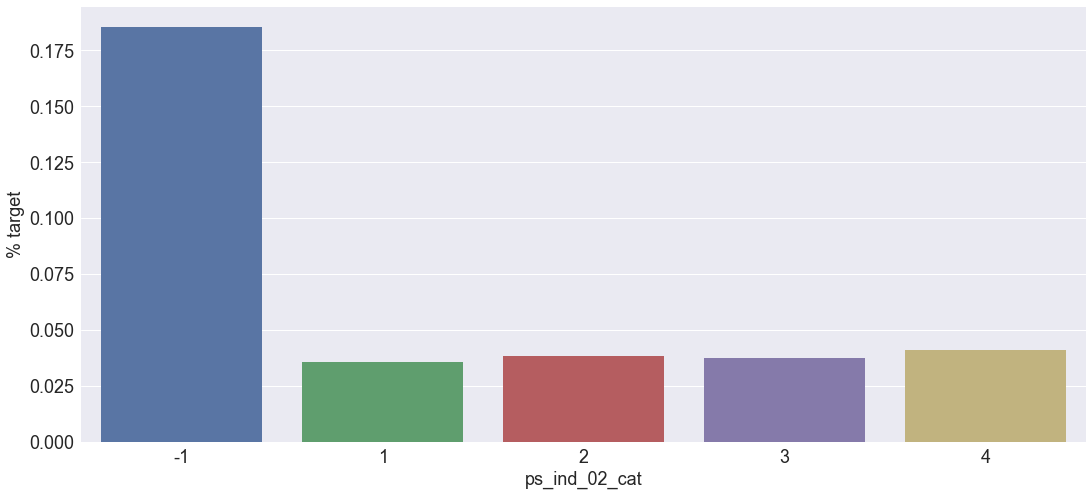

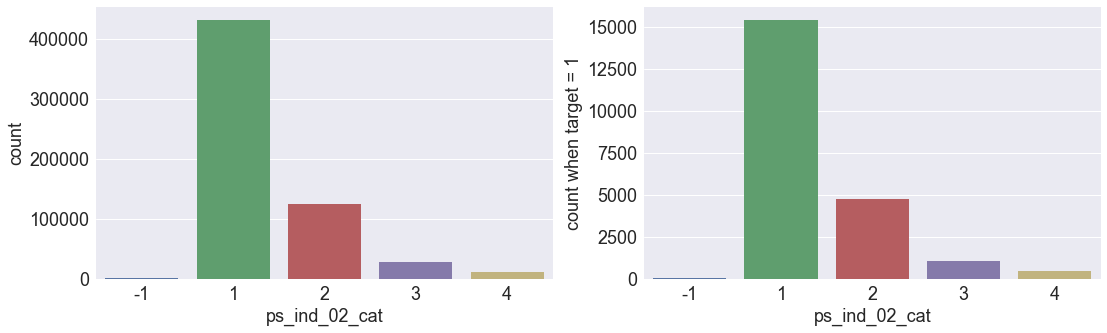

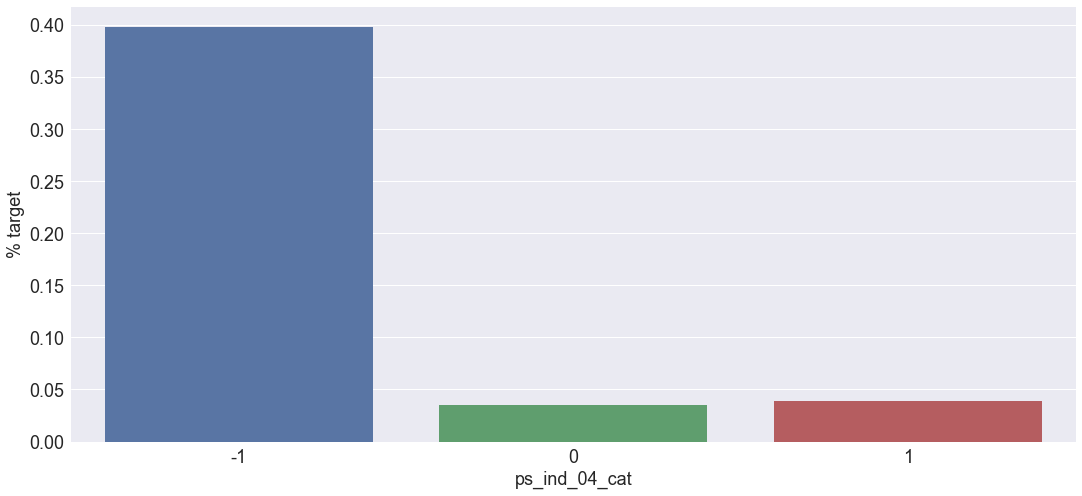

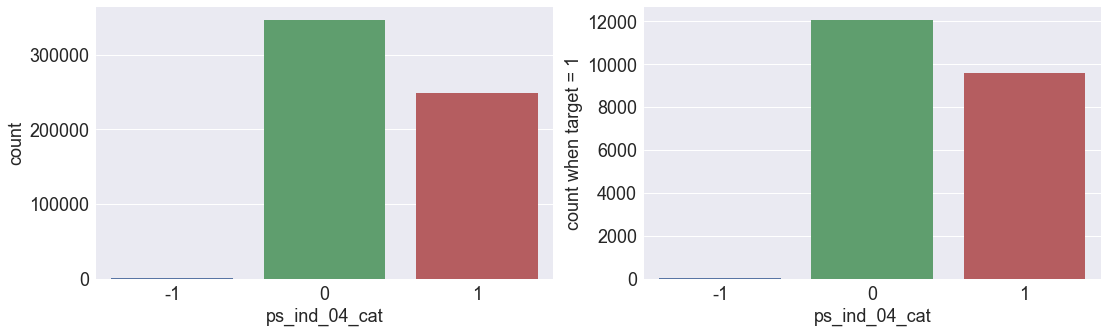

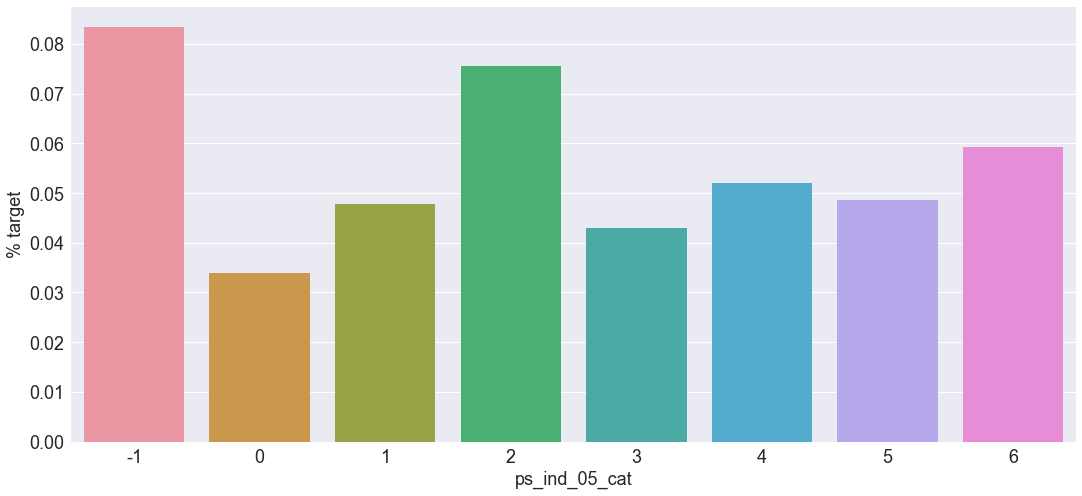

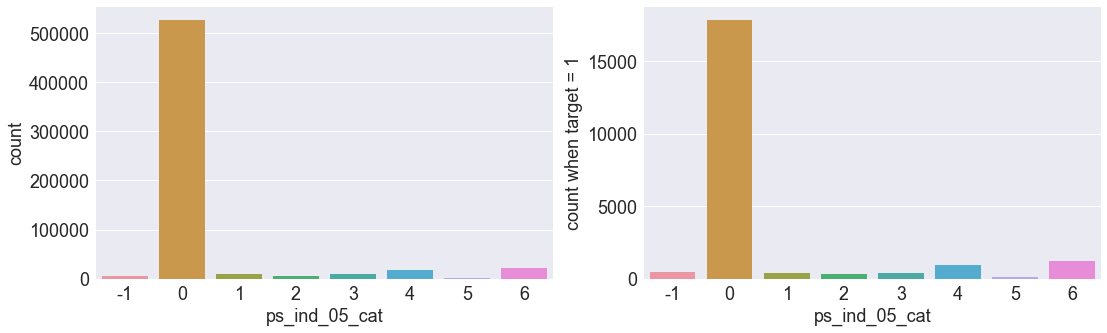

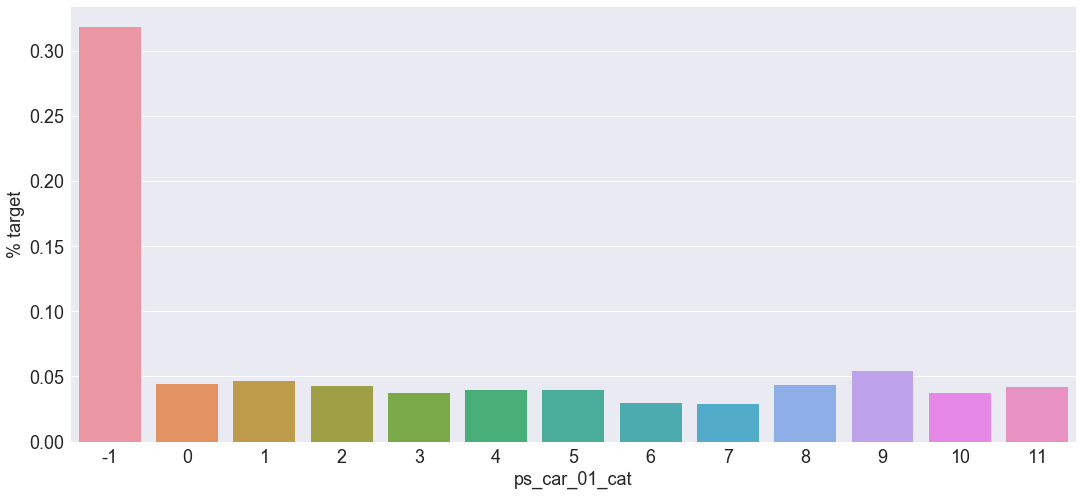

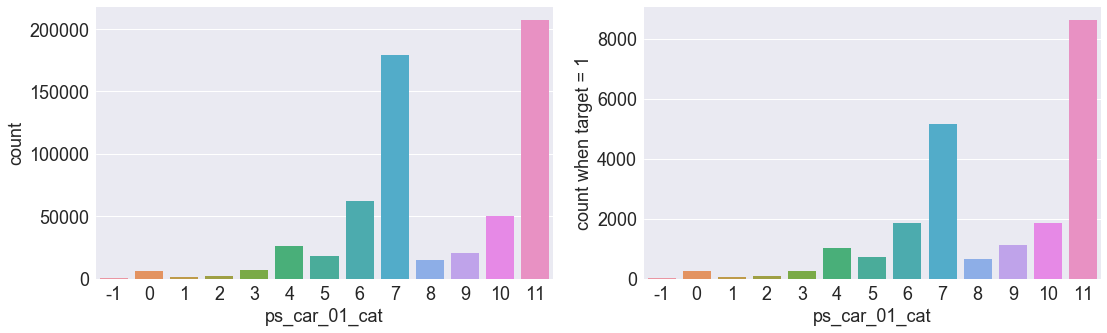

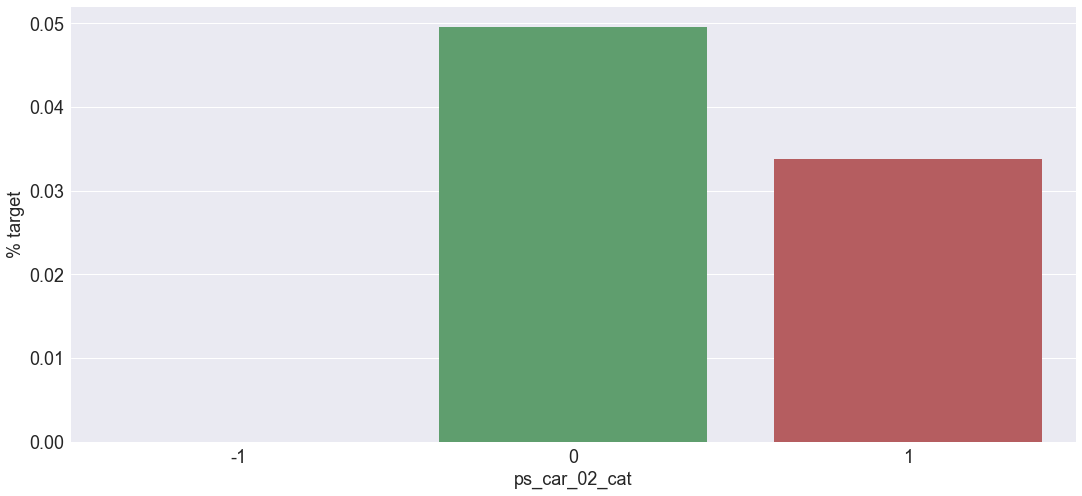

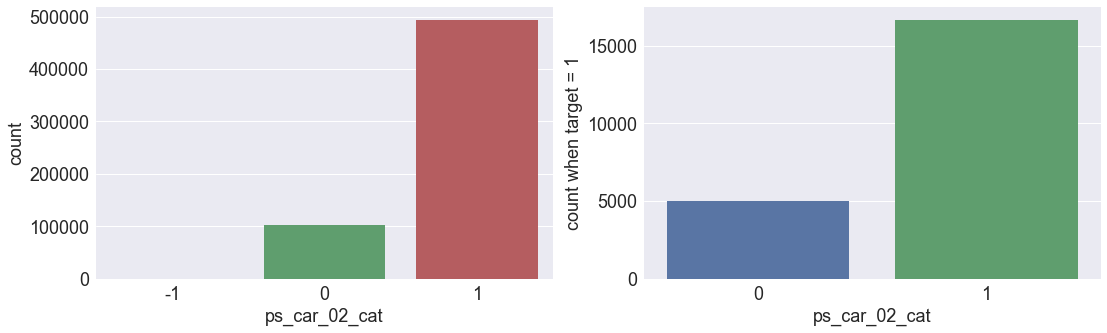

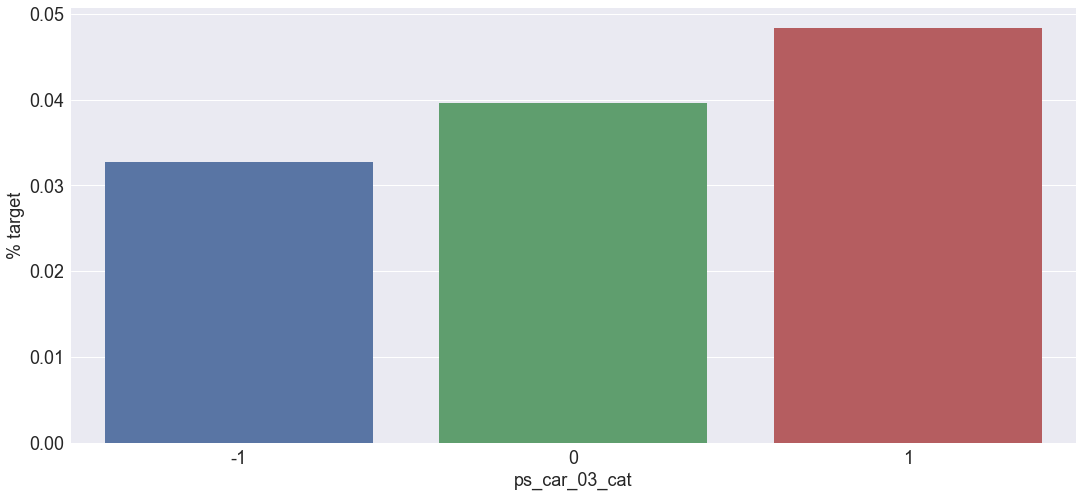

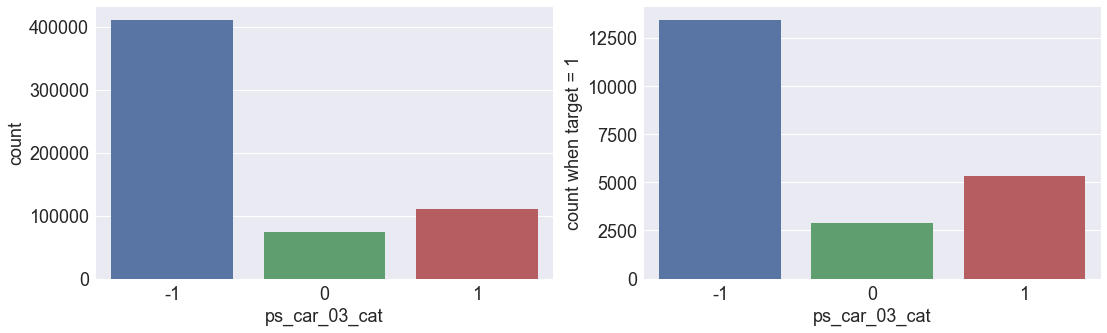

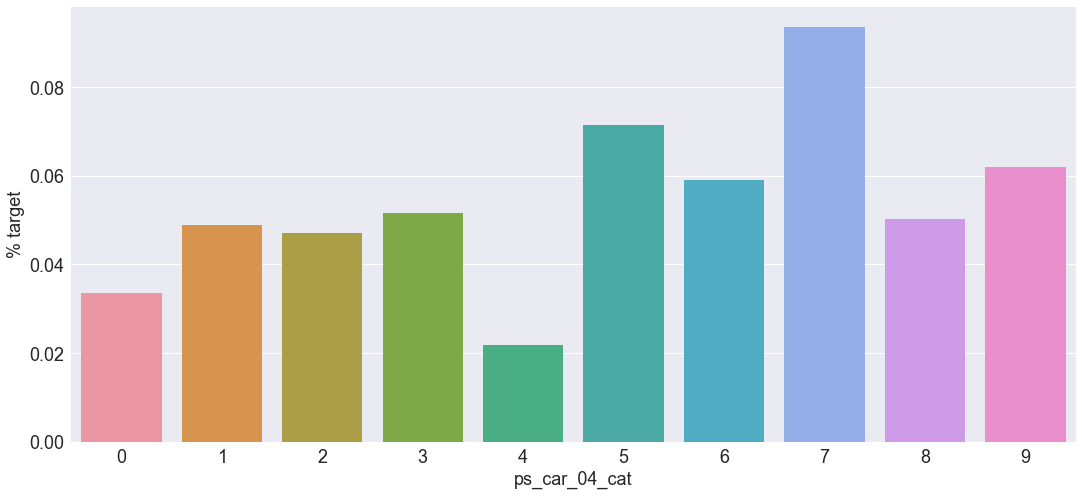

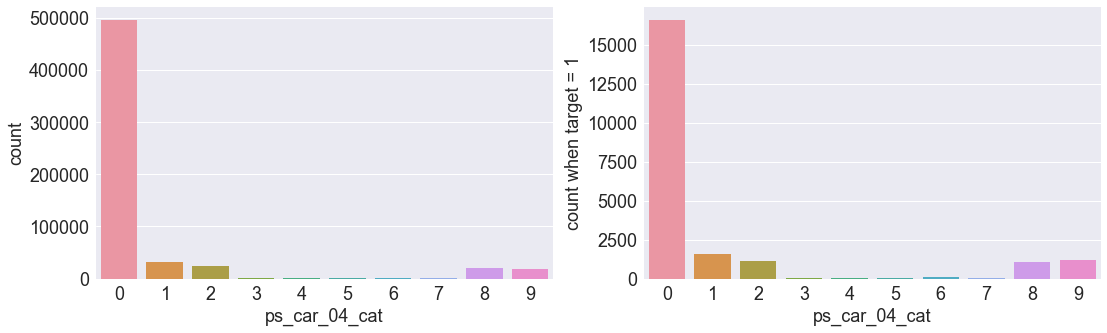

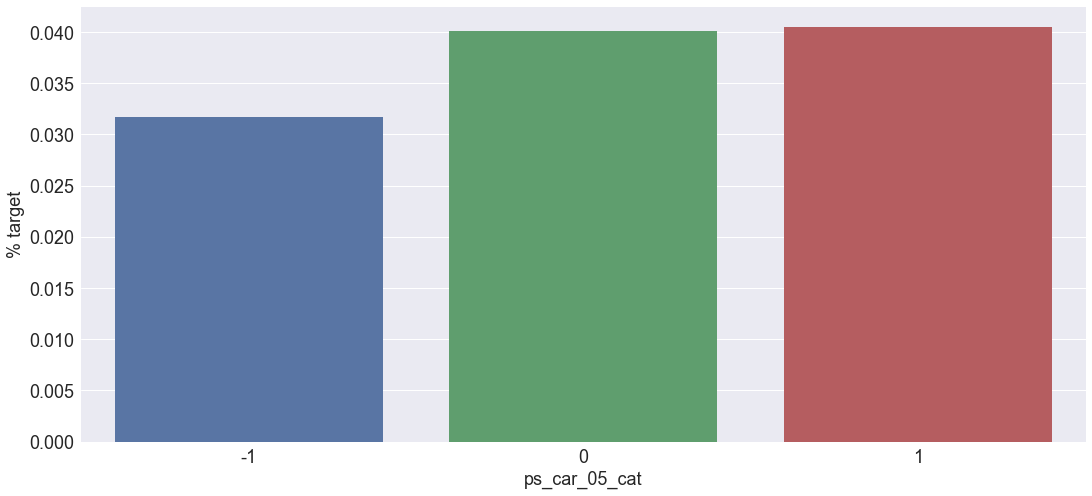

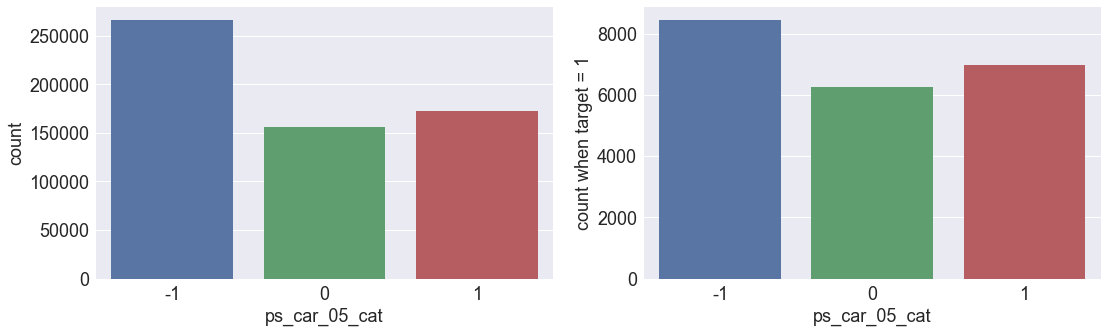

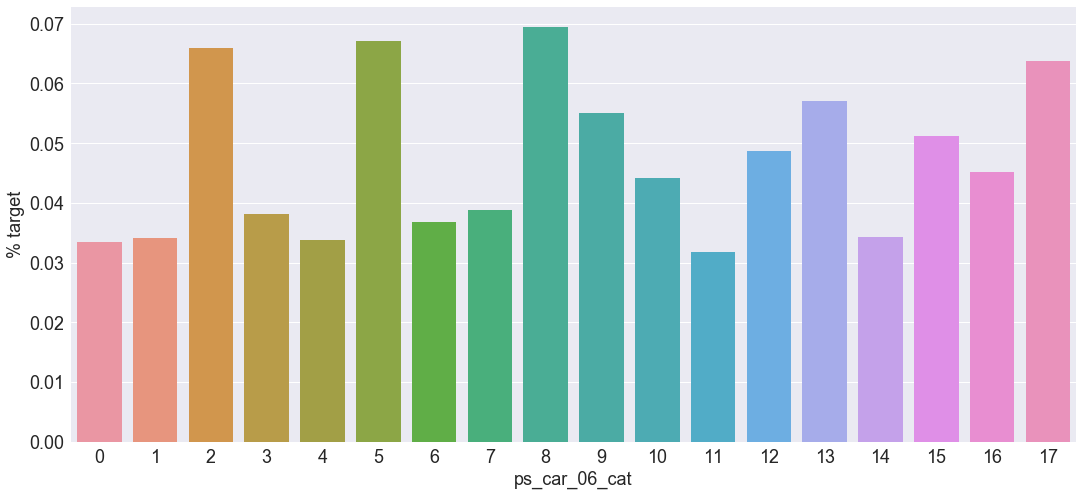

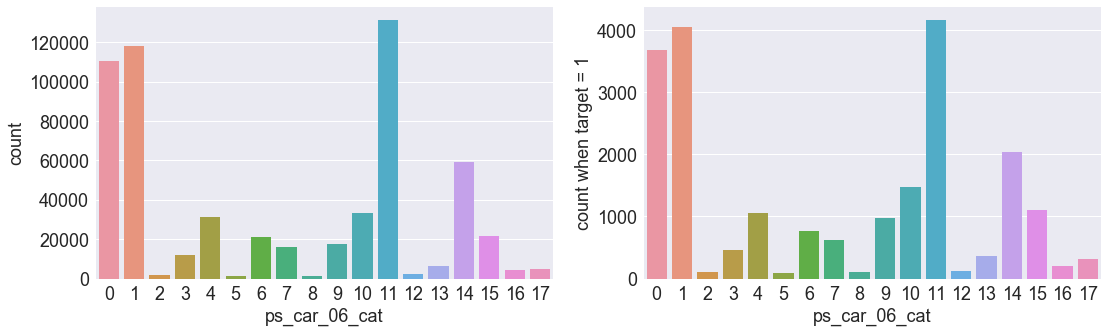

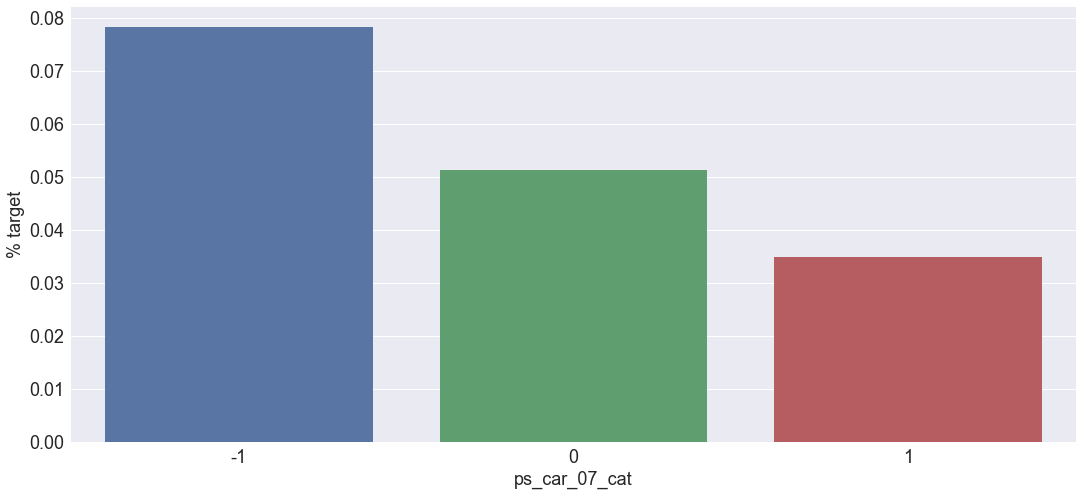

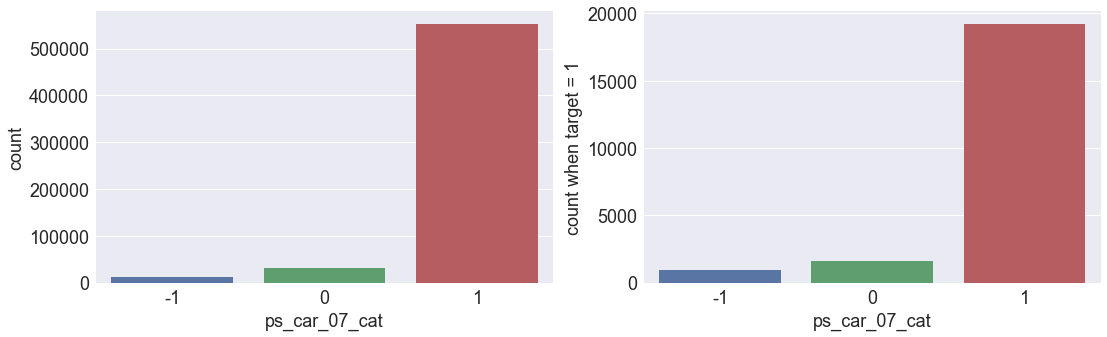

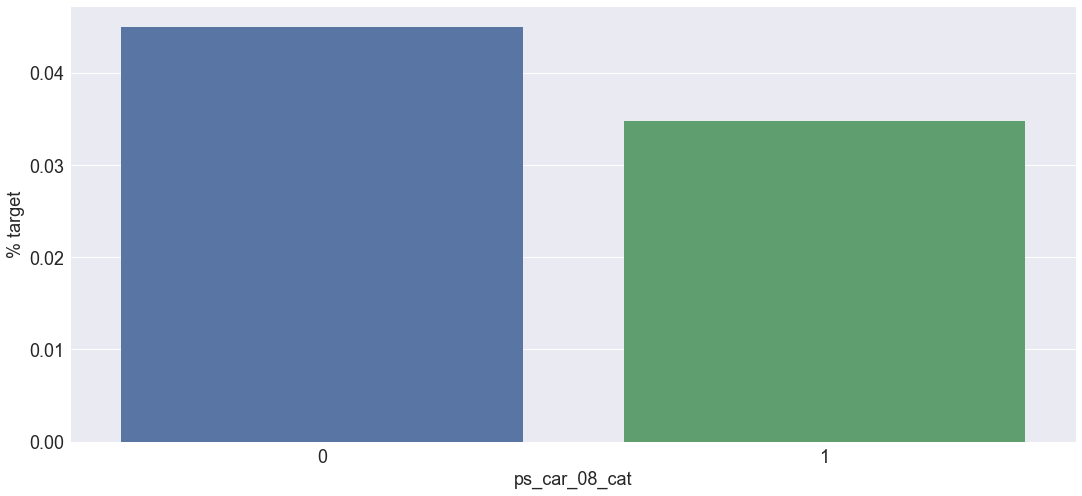

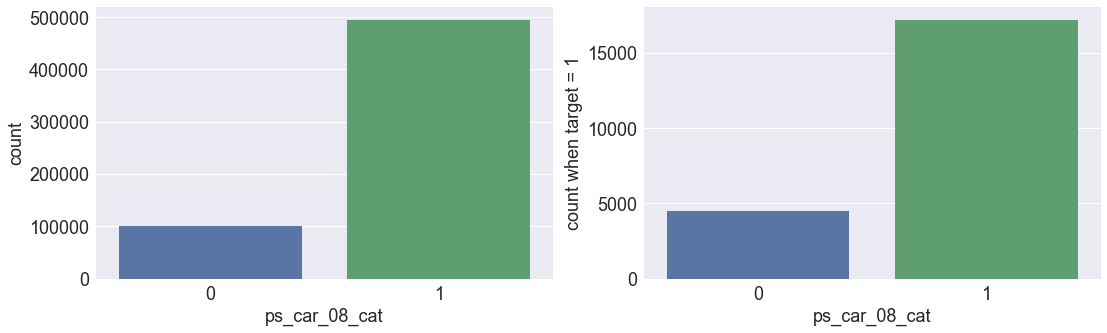

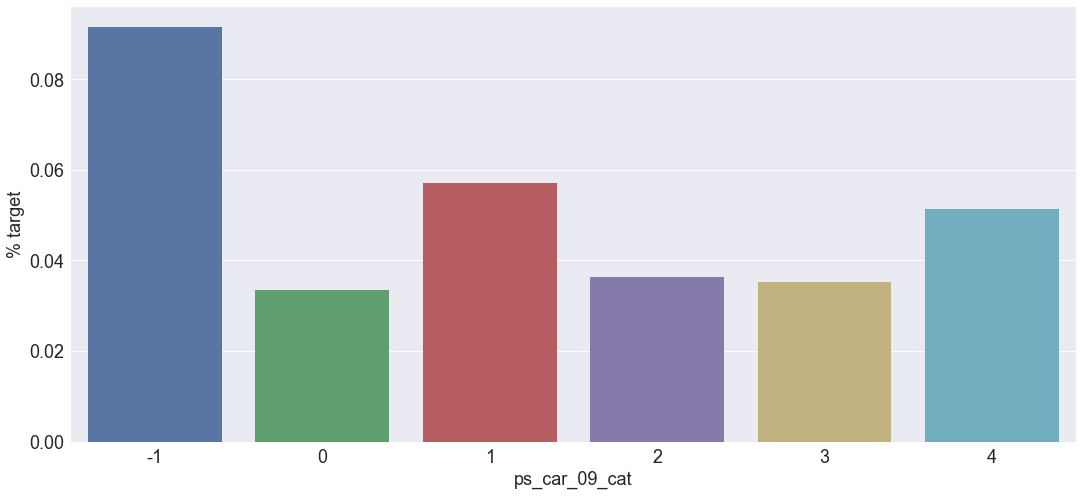

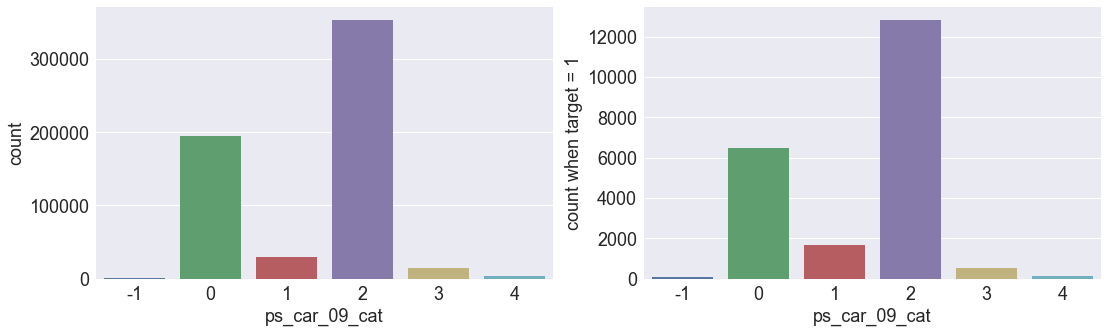

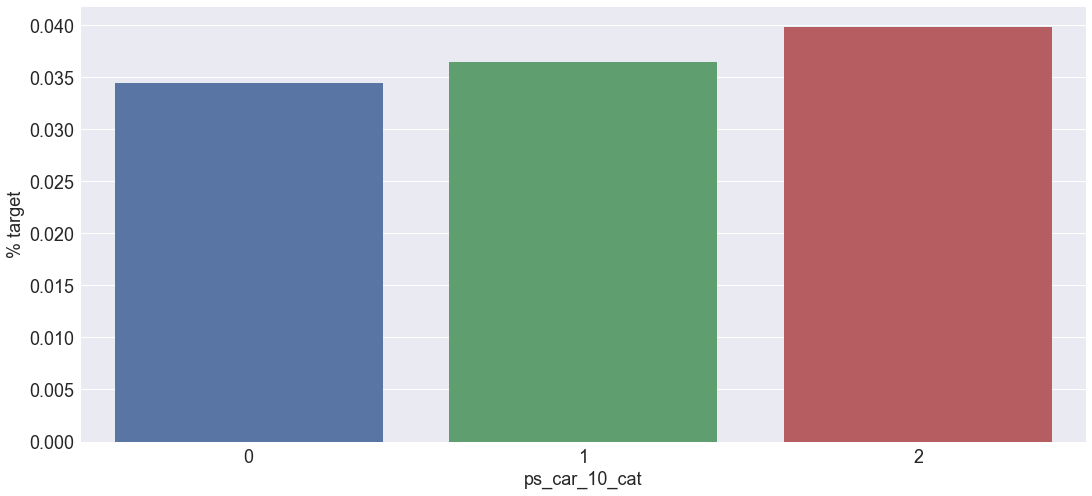

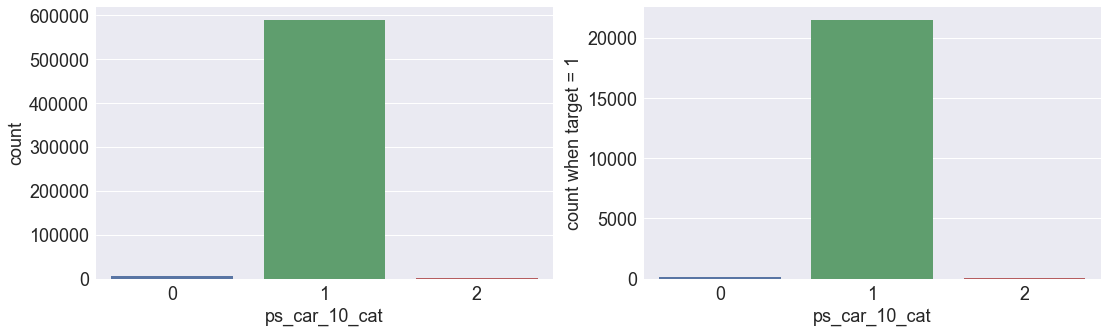

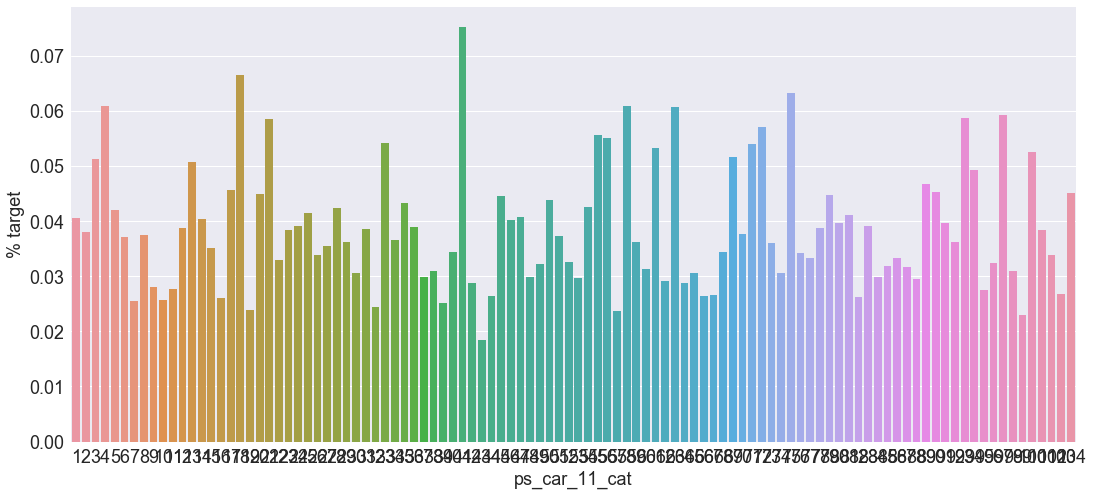

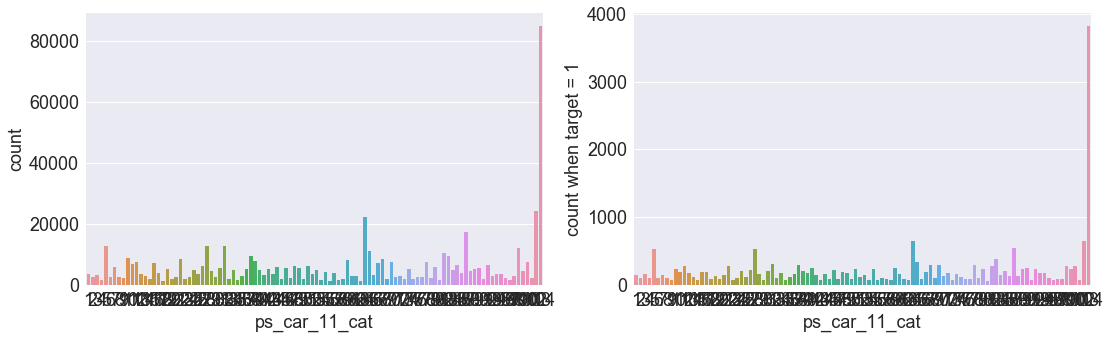

In [18]:
for f in metadata[metadata.type == 'categorical'].index:
    plt.figure()
    fig, ax = plt.subplots(figsize=(18,8))
    # Calculate the percentage of target=1 per category value
    cat_perc = data[[f, 'target']].groupby([f],as_index=False).mean()
    # Bar plot
    # Order the bars descending on target mean
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc)
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show();
    
    plt.figure()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
    
    sns.countplot(data[f], ax=ax1);
    ax1.tick_params(axis='both', which='major', labelsize=18)
    ax1.set_ylabel('count', fontsize=18)
    ax1.set_xlabel(f, fontsize=18)
    
    sns.countplot(data[data['target'] == 1][f], ax=ax2);
    ax2.tick_params(axis='both', which='major', labelsize=18)
    ax2.set_ylabel('count when target = 1', fontsize=18)
    ax2.set_xlabel(f, fontsize=18)
    
    plt.show();

### Implementation

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)

In [20]:
# default values from docs, non-default values explained

clf = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 100,
    silent = False,
    n_jobs = 4,                # use all my processors
    gamma = 0,
    min_child_weight=1,
    max_delta_step = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)

clf.fit(x_train, y_train, eval_metric ='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=-1, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [21]:
index_class_true = clf.classes_[clf.classes_ == 1]
predictions_train = clf.predict_proba(x_train)[:, index_class_true]
predictions_test = clf.predict_proba(x_test)[:, index_class_true]

print("Train score: {0:.5f}".format(roc_auc_score(y_train, predictions_train)))
print("Test score: {0:.5f}".format(roc_auc_score(y_test, predictions_test)))

Train score: 0.65000
Test score: 0.62513


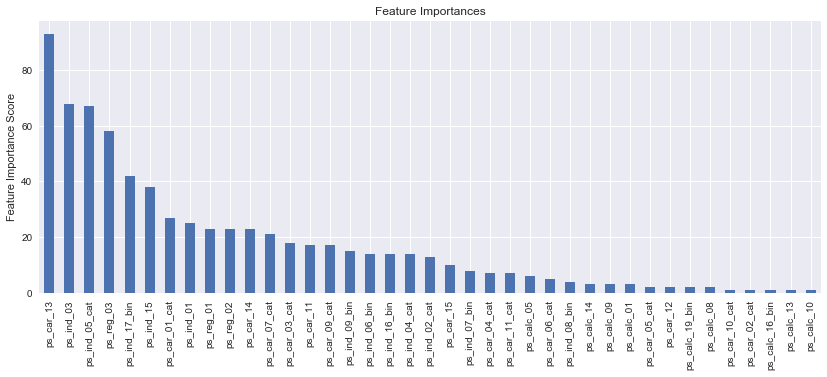

In [22]:
feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending = False)

plt.figure(figsize=(14,5))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

**Great!** With default settings we have already got better results than our benchmark model (Naive Bayes).

What about using encoded categorical features?

In [20]:
x_train_enc = pd.get_dummies(x_train, columns = cat_data_index)
x_test_enc = pd.get_dummies(x_test, columns = cat_data_index)

In [35]:
clf2 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.1,
    n_estimators = 100,
    silent = False,
    n_jobs = 4,                # use all my processors
    gamma = 0,
    min_child_weight=1,
    max_delta_step = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)

clf2.fit(x_train_enc, y_train, eval_metric ='auc')

index_class_true_enc = clf2.classes_[clf2.classes_ == 1]
predictions_train_enc = clf2.predict_proba(x_train_enc)[:, index_class_true_enc]
predictions_test_enc = clf2.predict_proba(x_test_enc)[:, index_class_true_enc]

In [36]:
print("Train score: {0:.5f}".format(roc_auc_score(y_train, predictions_train_enc)))
print("Test score: {0:.5f}".format(roc_auc_score(y_test, predictions_test_enc)))

Train score: 0.64998
Test score: 0.62544


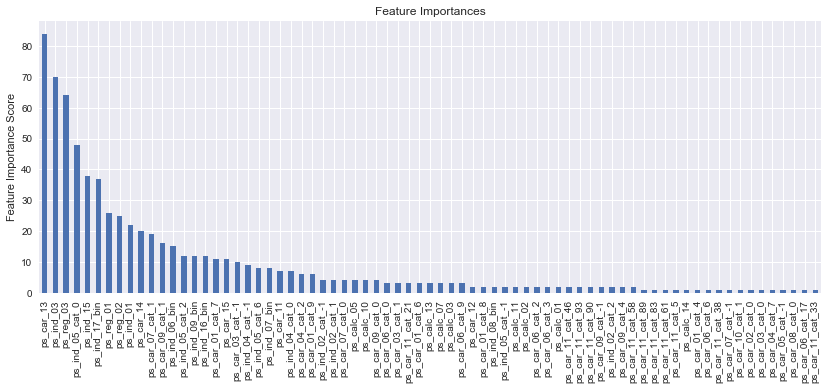

In [37]:
feat_imp = pd.Series(clf2.get_booster().get_fscore()).sort_values(ascending = False)

plt.figure(figsize=(14,5))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

Almost same result, being a bit better on test score.

Because of that we will be using the second model as base to compare to others.

Let's now fine tune and see if we can get it better.

As we will be training a classifier multiple times, let's create a function to help us.

Got this tip from Jain (https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [24]:
def train(clf, x, y, use_cross_validation = True, cv_folds = 5, early_stopping_rounds=50):
    
    if use_cross_validation:
        xgb_param = clf.get_xgb_params()
        xgtrain = xgboost.DMatrix(x, label = y)
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round = clf.get_params()['n_estimators'],
                              nfold = cv_folds, metrics = 'auc', early_stopping_rounds = early_stopping_rounds,
                              stratified = True, verbose_eval = 1, seed = 0)
        clf.set_params(n_estimators = cvresult.shape[0])
        print("Best number of estimators: {}".format(cvresult.shape[0]))
    
    clf.fit(x, y, eval_metric ='auc')
        
    index_class_true = clf.classes_[clf.classes_ == 1]
    predictions_train = clf.predict_proba(x)[:, index_class_true]

    print("Train score: {0:.5f}".format(roc_auc_score(y, predictions_train)))
    
    feat_imp = pd.Series(clf.get_booster().get_fscore()).sort_values(ascending = False)

    plt.figure(figsize=(14,5))
    feat_imp.nlargest(10).plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

Tuning number of estimators vs learning rate

[0]	train-auc:0.593682+0.000983038	test-auc:0.590194+0.00554451
[1]	train-auc:0.607029+0.00297059	test-auc:0.6039+0.00505516
[2]	train-auc:0.611075+0.00177604	test-auc:0.607103+0.00440909
[3]	train-auc:0.612837+0.00246654	test-auc:0.609445+0.00574616
[4]	train-auc:0.614662+0.00108264	test-auc:0.610881+0.00553093
[5]	train-auc:0.615164+0.000597797	test-auc:0.611772+0.00546243
[6]	train-auc:0.616466+0.00119917	test-auc:0.61242+0.0057674
[7]	train-auc:0.619473+0.00144505	test-auc:0.615616+0.00519356
[8]	train-auc:0.622064+0.00183683	test-auc:0.617717+0.00506946
[9]	train-auc:0.624108+0.00205258	test-auc:0.619047+0.00539089
[10]	train-auc:0.626004+0.00155515	test-auc:0.620575+0.00523388
[11]	train-auc:0.628852+0.00142045	test-auc:0.622945+0.00508118
[12]	train-auc:0.630988+0.00143064	test-auc:0.624788+0.00551037
[13]	train-auc:0.633347+0.00142584	test-auc:0.62623+0.00509836
[14]	train-auc:0.634821+0.00114178	test-auc:0.627619+0.00540426
[15]	train-auc:0.636264+0.00161598	test-auc:0.62813+0

[129]	train-auc:0.681548+0.000940324	test-auc:0.638175+0.00586229
[130]	train-auc:0.681696+0.00091473	test-auc:0.63822+0.00590593
[131]	train-auc:0.681936+0.000987317	test-auc:0.638161+0.00585736
[132]	train-auc:0.682231+0.00102775	test-auc:0.638161+0.0058211
[133]	train-auc:0.682515+0.000977682	test-auc:0.638133+0.00581329
[134]	train-auc:0.682833+0.00103425	test-auc:0.638078+0.00577714
[135]	train-auc:0.683127+0.000941503	test-auc:0.63813+0.00577201
[136]	train-auc:0.683427+0.000972008	test-auc:0.638096+0.00567484
[137]	train-auc:0.683722+0.00088795	test-auc:0.638009+0.00570762
[138]	train-auc:0.683909+0.00083506	test-auc:0.637987+0.00568049
[139]	train-auc:0.684206+0.000820907	test-auc:0.637966+0.00561874
[140]	train-auc:0.684472+0.000866562	test-auc:0.637924+0.00559751
[141]	train-auc:0.684699+0.000887327	test-auc:0.637934+0.00557779
[142]	train-auc:0.684927+0.000946768	test-auc:0.637875+0.00559538
[143]	train-auc:0.685187+0.000952788	test-auc:0.63777+0.00557264
[144]	train-auc:0.6

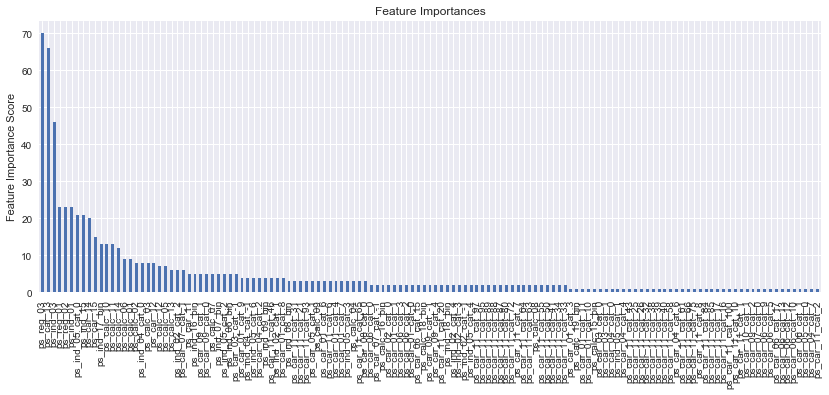

In [39]:
clf3 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.3,       # let's get it a bit higher so we can get results faster
    n_estimators = 1000,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0,
    min_child_weight=1,
    max_delta_step = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf3, x_train_enc, y_train)

Train score: 0.68061


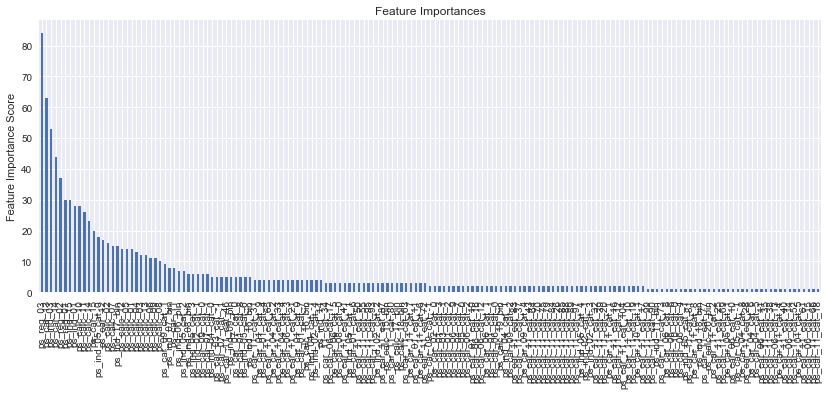

CPU times: user 1min 18s, sys: 3.13 s, total: 1min 21s
Wall time: 27.5 s


In [28]:
clf4 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.3,       # let's get it a bit higher so we can get results faster
    n_estimators = 100,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0,
    min_child_weight=1,
    max_delta_step = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf4, x_train_enc, y_train, False)

Tuning max_depth and min_child_height

In [29]:
param_test1 = {
    'max_depth': range(3, 10, 3),
    'min_child_weight': range(1,6,2)
}

gsearch1 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 100,
        silent = False,
        n_jobs = 4,                
        gamma = 0,
        min_child_weight=1,
        max_delta_step = 0,
        subsample = 1,
        colsample_bytree = 1,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test1,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch1.fit(x_train_enc, y_train)

gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.6326271842235277, total=  16.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.1s remaining:    0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.6284347045553724, total=  17.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.3s remaining:    0.0s
[CV] max_depth=3, min_child_weight=1 .................................
[CV]  max_depth=3, min_child_weight=1, score=0.6399737837850087, total=  18.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   57.7s remaining:    0.0s
[CV] max_depth=3, min_child_weight=3 .................................
[CV]  max_depth=3, min_child_weight=3, score=0.6336945302728749, total=  17.9s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[CV] max_depth=3, mi

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.63368, std: 0.00477, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.63485, std: 0.00544, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.63500, std: 0.00532, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.61008, std: 0.00248, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.60811, std: 0.00569, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: 0.61138, std: 0.00657, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.57943, std: 0.00226, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.57673, std: 0.00423, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.57909, std: 0.00207, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 3, 'min_child_weight': 5},
 0.63499756836139321)

In [30]:
param_test2 = {
    'max_depth': [3,4],
    'min_child_weight': [4,5,6]
}

gsearch2 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 100,
        silent = False,
        n_jobs = 4,                
        gamma = 0,
        min_child_weight=1,
        max_delta_step = 0,
        subsample = 1,
        colsample_bytree = 1,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test2,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch2.fit(x_train_enc, y_train)

gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.6319843027774978, total=  15.1s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.0s remaining:    0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.6286554955249151, total=  15.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   34.0s remaining:    0.0s
[CV] max_depth=3, min_child_weight=4 .................................
[CV]  max_depth=3, min_child_weight=4, score=0.6385090063046659, total=  17.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   53.5s remaining:    0.0s
[CV] max_depth=3, min_child_weight=5 .................................
[CV]  max_depth=3, min_child_weight=5, score=0.6335917352717361, total=  17.2s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s
[CV] max_depth=3, mi

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael

({'mean_fit_time': array([ 14.80938045,  15.13375243,  15.65678581,  19.84568803,
          20.60643514,  17.85053865]),
  'mean_score_time': array([ 1.01014845,  1.00273975,  1.00629465,  1.2007513 ,  1.31036878,
          1.11726491]),
  'mean_test_score': array([ 0.6330496 ,  0.63499757,  0.63397459,  0.6286797 ,  0.62841888,
          0.62677817]),
  'mean_train_score': array([ 0.69303302,  0.69322133,  0.69315609,  0.73658008,  0.73563907,
          0.73519291]),
  'param_max_depth': masked_array(data = [3 3 3 4 4 4],
               mask = [False False False False False False],
         fill_value = ?),
  'param_min_child_weight': masked_array(data = [4 5 6 4 5 6],
               mask = [False False False False False False],
         fill_value = ?),
  'params': [{'max_depth': 3, 'min_child_weight': 4},
   {'max_depth': 3, 'min_child_weight': 5},
   {'max_depth': 3, 'min_child_weight': 6},
   {'max_depth': 4, 'min_child_weight': 4},
   {'max_depth': 4, 'min_child_weight': 5},
   {

[0]	train-auc:0.593682+0.000983038	test-auc:0.590194+0.00554451
[1]	train-auc:0.607171+0.00302834	test-auc:0.603915+0.00489422
[2]	train-auc:0.611582+0.00147338	test-auc:0.607717+0.00440199
[3]	train-auc:0.613572+0.00211818	test-auc:0.610126+0.0059621
[4]	train-auc:0.61451+0.00137727	test-auc:0.610701+0.00531283
[5]	train-auc:0.615529+0.000583743	test-auc:0.61204+0.0055793
[6]	train-auc:0.616589+0.000826906	test-auc:0.612853+0.00589451
[7]	train-auc:0.618709+0.00121014	test-auc:0.615513+0.00607235
[8]	train-auc:0.621786+0.0012151	test-auc:0.618267+0.00472636
[9]	train-auc:0.624268+0.00179782	test-auc:0.619886+0.00497249
[10]	train-auc:0.627089+0.00195697	test-auc:0.622211+0.00550556
[11]	train-auc:0.628835+0.00183558	test-auc:0.622906+0.00500057
[12]	train-auc:0.631134+0.00155814	test-auc:0.624491+0.00481707
[13]	train-auc:0.632898+0.00130243	test-auc:0.625924+0.00483887
[14]	train-auc:0.634263+0.00150756	test-auc:0.626692+0.00507389
[15]	train-auc:0.635625+0.00177338	test-auc:0.627891

[129]	train-auc:0.681266+0.00117092	test-auc:0.638235+0.00541229
[130]	train-auc:0.681506+0.00122157	test-auc:0.638112+0.00551837
[131]	train-auc:0.681773+0.00127453	test-auc:0.638079+0.00551551
[132]	train-auc:0.681992+0.00123547	test-auc:0.638115+0.00562767
[133]	train-auc:0.682216+0.00126228	test-auc:0.638174+0.00553007
[134]	train-auc:0.682484+0.0012789	test-auc:0.638223+0.00541122
[135]	train-auc:0.682761+0.00130481	test-auc:0.638198+0.00545187
[136]	train-auc:0.683026+0.00130074	test-auc:0.638263+0.00537334
[137]	train-auc:0.683188+0.00131152	test-auc:0.638198+0.00535208
[138]	train-auc:0.683341+0.00124523	test-auc:0.638168+0.00541741
[139]	train-auc:0.683527+0.00120998	test-auc:0.638155+0.0055605
[140]	train-auc:0.683809+0.00116519	test-auc:0.638241+0.00554094
[141]	train-auc:0.684116+0.00115309	test-auc:0.63822+0.00546027
[142]	train-auc:0.684393+0.00106006	test-auc:0.638119+0.00549455
[143]	train-auc:0.68454+0.00111162	test-auc:0.638196+0.00561935
[144]	train-auc:0.684705+0.00

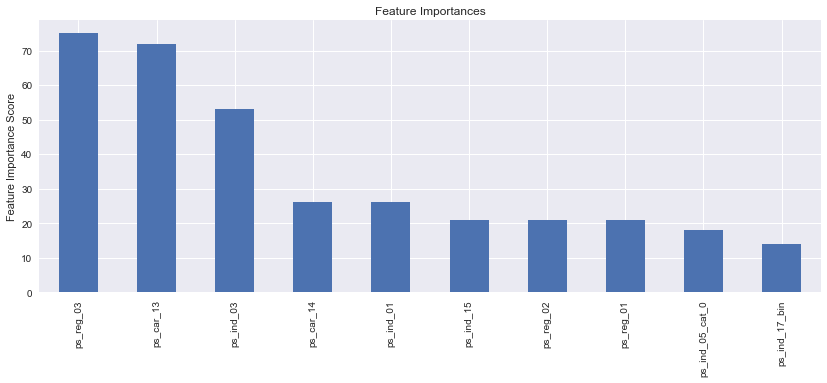

In [35]:
clf4 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.3,       # let's get it a bit higher so we can get results faster
    n_estimators = 1000,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0,
    min_child_weight=5,
    max_delta_step = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf4, x_train_enc, y_train)

Now, we can tune "gamma":

In [36]:
param_test3 = {
    'gamma': [i/10.0 for i in range(0,5)]
}

gsearch3 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 104,
        silent = False,
        n_jobs = 4,                
        gamma = 0,
        min_child_weight=5,
        max_delta_step = 0,
        subsample = 1,
        colsample_bytree = 1,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test3,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch3.fit(x_train_enc, y_train)

gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.6353698488921677, total=  16.7s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.0s remaining:    0.0s
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.6299745905699321, total=  19.2s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.7s remaining:    0.0s
[CV] gamma=0.0 .......................................................
[CV] .............. gamma=0.0, score=0.6426804403924455, total=  16.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   59.1s remaining:    0.0s
[CV] gamma=0.1 .......................................................
[CV] .............. gamma=0.1, score=0.6353698488921677, total=  16.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s
[CV] gamma=0.1 .....................................

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael

({'mean_fit_time': array([ 16.0331014 ,  14.52019183,  14.93213836,  15.81051405,  15.09924237]),
  'mean_score_time': array([ 1.26219487,  1.24427811,  1.28943054,  1.30000321,  1.30100648]),
  'mean_test_score': array([ 0.63600829,  0.63600829,  0.63600829,  0.63614878,  0.63614878]),
  'mean_train_score': array([ 0.68103809,  0.68103809,  0.68103809,  0.6811146 ,  0.6811146 ]),
  'param_gamma': masked_array(data = [0.0 0.1 0.2 0.3 0.4],
               mask = [False False False False False],
         fill_value = ?),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'rank_test_score': array([3, 3, 3, 1, 1], dtype=int32),
  'split0_test_score': array([ 0.63536985,  0.63536985,  0.63536985,  0.63536985,  0.63536985]),
  'split0_train_score': array([ 0.68218182,  0.68218182,  0.68218182,  0.68218182,  0.68218182]),
  'split1_test_score': array([ 0.62997459,  0.62997459,  0.62997459,  0.63039604,  0.63039604]),
  'split1_train_sco

[0]	train-auc:0.593682+0.000983038	test-auc:0.590194+0.00554451
[1]	train-auc:0.607171+0.00302834	test-auc:0.603915+0.00489422
[2]	train-auc:0.611582+0.00147338	test-auc:0.607717+0.00440199
[3]	train-auc:0.613572+0.00211818	test-auc:0.610126+0.0059621
[4]	train-auc:0.61451+0.00137727	test-auc:0.610701+0.00531283
[5]	train-auc:0.615529+0.000583743	test-auc:0.61204+0.0055793
[6]	train-auc:0.616589+0.000826906	test-auc:0.612853+0.00589451
[7]	train-auc:0.618709+0.00121014	test-auc:0.615513+0.00607235
[8]	train-auc:0.621786+0.0012151	test-auc:0.618267+0.00472636
[9]	train-auc:0.624268+0.00179782	test-auc:0.619886+0.00497249
[10]	train-auc:0.627089+0.00195697	test-auc:0.622211+0.00550556
[11]	train-auc:0.628835+0.00183558	test-auc:0.622906+0.00500057
[12]	train-auc:0.631134+0.00155814	test-auc:0.624491+0.00481707
[13]	train-auc:0.632898+0.00130243	test-auc:0.625924+0.00483887
[14]	train-auc:0.634263+0.00150756	test-auc:0.626692+0.00507389
[15]	train-auc:0.635625+0.00177338	test-auc:0.627891

[129]	train-auc:0.681266+0.00117092	test-auc:0.638235+0.00541229
[130]	train-auc:0.681506+0.00122157	test-auc:0.638112+0.00551837
[131]	train-auc:0.681773+0.00127453	test-auc:0.638079+0.00551551
[132]	train-auc:0.681992+0.00123547	test-auc:0.638115+0.00562767
[133]	train-auc:0.682216+0.00126228	test-auc:0.638174+0.00553007
[134]	train-auc:0.682484+0.0012789	test-auc:0.638223+0.00541122
[135]	train-auc:0.682761+0.00130481	test-auc:0.638198+0.00545187
[136]	train-auc:0.683026+0.00130074	test-auc:0.638263+0.00537334
[137]	train-auc:0.683188+0.00131152	test-auc:0.638198+0.00535208
[138]	train-auc:0.683341+0.00124523	test-auc:0.638168+0.00541741
[139]	train-auc:0.683527+0.00120998	test-auc:0.638155+0.0055605
[140]	train-auc:0.683809+0.00116519	test-auc:0.638241+0.00554094
[141]	train-auc:0.684116+0.00115309	test-auc:0.63822+0.00546027
[142]	train-auc:0.684393+0.00106006	test-auc:0.638119+0.00549455
[143]	train-auc:0.68454+0.00111162	test-auc:0.638196+0.00561935
[144]	train-auc:0.684705+0.00

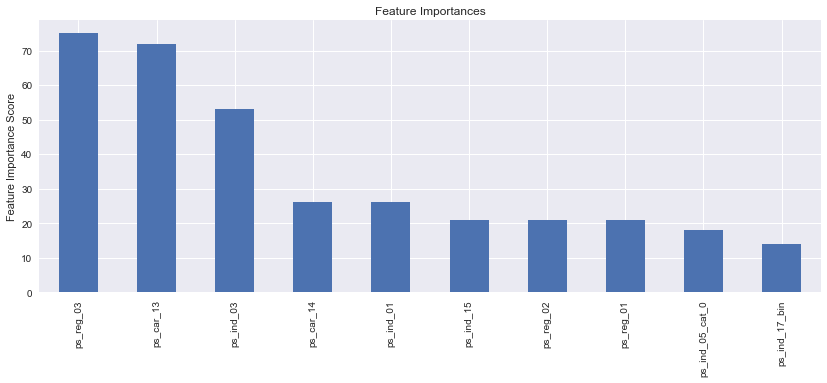

In [24]:
clf5 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.3,       # let's get it a bit higher so we can get results faster
    n_estimators = 1000,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0.3,
    min_child_weight=5,
    max_delta_step = 0,
    subsample = 1,
    colsample_bytree = 1,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf5, x_train_enc, y_train)

Tuning subsample and colsample_bytree

In [25]:
param_test4 = {
 'subsample':[i/10.0 for i in range(7,10)],
 'colsample_bytree':[i/10.0 for i in range(7,10)]
}

gsearch4 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 104,
        silent = False,
        n_jobs = 4,                
        gamma = 0.3,
        min_child_weight=5,
        max_delta_step = 0,
        subsample = 1,
        colsample_bytree = 1,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test4,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch4.fit(x_train_enc, y_train)

gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.6357102425053291, total=  26.9s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.3s remaining:    0.0s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.6299925499549685, total=  27.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s
[CV] colsample_bytree=0.7, subsample=0.7 .............................
[CV]  colsample_bytree=0.7, subsample=0.7, score=0.6378550861013461, total=  24.4s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.5min remaining:    0.0s
[CV] colsample_bytree=0.7, subsample=0.8 .............................
[CV]  colsample_bytree=0.7, subsample=0.8, score=0.6339220265542101, total=  26.3s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.0min remaining:    0.0s
[CV]

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael

({'mean_fit_time': array([ 24.85564661,  25.00322596,  22.12410633,  20.2875851 ,
          20.94085598,  21.65036964,  21.20978578,  20.79153824,  21.81290658]),
  'mean_score_time': array([ 1.50732406,  1.4516178 ,  1.3928264 ,  1.34862351,  1.35701466,
          1.3905127 ,  1.38849449,  1.34803597,  1.34492675]),
  'mean_test_score': array([ 0.63451929,  0.63401413,  0.63500679,  0.6336023 ,  0.6349951 ,
          0.63513474,  0.63349189,  0.63421527,  0.63447224]),
  'mean_train_score': array([ 0.67759046,  0.67826732,  0.67961739,  0.67835943,  0.67973183,
          0.68017128,  0.67938103,  0.67971514,  0.68036287]),
  'param_colsample_bytree': masked_array(data = [0.7 0.7 0.7 0.8 0.8 0.8 0.9 0.9 0.9],
               mask = [False False False False False False False False False],
         fill_value = ?),
  'param_subsample': masked_array(data = [0.7 0.8 0.9 0.7 0.8 0.9 0.7 0.8 0.9],
               mask = [False False False False False False False False False],
         fill_val

[0]	train-auc:0.591276+0.00220356	test-auc:0.586671+0.00415333
[1]	train-auc:0.607241+0.00252701	test-auc:0.60212+0.00394703
[2]	train-auc:0.61245+0.00307574	test-auc:0.607879+0.00684259
[3]	train-auc:0.613017+0.00227546	test-auc:0.608594+0.00609437
[4]	train-auc:0.615057+0.00224796	test-auc:0.611601+0.0055942
[5]	train-auc:0.615822+0.00164009	test-auc:0.612099+0.0058723
[6]	train-auc:0.619041+0.00118237	test-auc:0.615524+0.00541179
[7]	train-auc:0.62148+0.0014257	test-auc:0.617866+0.0061513
[8]	train-auc:0.622741+0.00152526	test-auc:0.618602+0.00598447
[9]	train-auc:0.625038+0.00106721	test-auc:0.62053+0.00581739
[10]	train-auc:0.627346+0.00212266	test-auc:0.621693+0.00496367
[11]	train-auc:0.629385+0.00163345	test-auc:0.623283+0.00480413
[12]	train-auc:0.6311+0.00104703	test-auc:0.624385+0.00482862
[13]	train-auc:0.632735+0.00115973	test-auc:0.626178+0.0051021
[14]	train-auc:0.63457+0.00120452	test-auc:0.627596+0.00488175
[15]	train-auc:0.63601+0.00168451	test-auc:0.628737+0.00463207

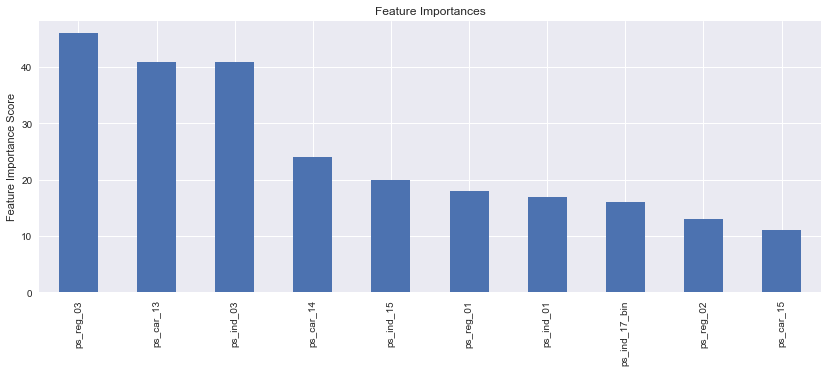

In [26]:
clf6 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.3,       # let's get it a bit higher so we can get results faster
    n_estimators = 1000,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0.3,
    min_child_weight=5,
    max_delta_step = 0,
    subsample = 0.9,
    colsample_bytree = 0.8,
    colsample_bylevel = 1,
    reg_alpha = 0,
    reg_lambda = 1,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf6, x_train_enc, y_train)

In [21]:
param_test5 = {
 'reg_alpha':[0, 1e-2, 0.1, 1, 10],
 'reg_lambda':[0, 1e-2, 0.1, 1, 10]
}

gsearch5 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 75,
        silent = False,
        n_jobs = 4,                
        gamma = 0.3,
        min_child_weight=5,
        max_delta_step = 0,
        subsample = 0.9,
        colsample_bytree = 0.8,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test5,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch5.fit(x_train_enc, y_train)

gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV]  reg_alpha=0, reg_lambda=0, score=0.6345813737368089, total=  16.2s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.2s remaining:    0.0s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV]  reg_alpha=0, reg_lambda=0, score=0.630790860132757, total=  17.6s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   38.4s remaining:    0.0s
[CV] reg_alpha=0, reg_lambda=0 .......................................
[CV]  reg_alpha=0, reg_lambda=0, score=0.6396821143072726, total=  17.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.1s remaining:    0.0s
[CV] reg_alpha=0, reg_lambda=0.01 ....................................
[CV]  reg_alpha=0, reg_lambda=0.01, score=0.6345849323839523, total=  14.6s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.2min remaining:    0.0s
[CV] reg_alpha=0, reg_lambda=0.01 .......

[CV]  reg_alpha=0.1, reg_lambda=0.1, score=0.6353374712500925, total=  19.7s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed: 12.5min remaining:    0.0s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV]  reg_alpha=0.1, reg_lambda=0.1, score=0.6310176533877231, total=  17.8s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed: 12.8min remaining:    0.0s
[CV] reg_alpha=0.1, reg_lambda=0.1 ...................................
[CV]  reg_alpha=0.1, reg_lambda=0.1, score=0.6397651556237594, total=  20.6s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed: 13.2min remaining:    0.0s
[CV] reg_alpha=0.1, reg_lambda=1 .....................................
[CV]  reg_alpha=0.1, reg_lambda=1, score=0.6337903916481914, total=  19.2s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 13.5min remaining:    0.0s
[CV] reg_alpha=0.1, reg_lambda=1 .....................................
[CV]  reg_alpha=0.1, reg_lambda=1, score=0.6325339332009436, total=  18.6s
[Parallel(n_job

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael

({'mean_fit_time': array([ 15.94370015,  15.60449553,  15.66910021,  18.20510793,
          17.08901676,  17.1321679 ,  18.1535306 ,  19.04510403,
          15.82054996,  16.63438511,  16.42753339,  16.51617233,
          18.34387581,  16.5898385 ,  16.76060295,  16.45032875,
          17.45308781,  21.91038497,  19.19235269,  15.72328122,
          15.7301089 ,  16.26474675,  19.76600345,  17.44836259,  19.18045362]),
  'mean_score_time': array([ 1.09155973,  1.0502944 ,  0.98815457,  1.13597155,  1.05286757,
          1.08858705,  1.30486623,  1.21223044,  1.02101262,  1.1135757 ,
          0.99440773,  1.05368106,  1.01801213,  1.43465026,  1.0471189 ,
          1.08056919,  1.09869862,  1.1862545 ,  0.93799655,  0.94734033,
          1.08767176,  1.04663746,  1.15687029,  1.05870732,  1.17529257]),
  'mean_test_score': array([ 0.63501812,  0.634713  ,  0.6349032 ,  0.63587435,  0.63572464,
          0.63497991,  0.63516426,  0.63419858,  0.63585992,  0.6358267 ,
          0.6353397

In [28]:
param_test6 = {
 'reg_alpha':[7, 10, 13, 20],
 'reg_lambda':[0.05, 0.1, 0.2]
}

gsearch6 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 75,
        silent = False,
        n_jobs = 4,                
        gamma = 0.3,
        min_child_weight=5,
        max_delta_step = 0,
        subsample = 0.9,
        colsample_bytree = 0.8,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test6,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch6.fit(x_train_enc, y_train)

gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] reg_alpha=7, reg_lambda=0.05 ....................................
[CV]  reg_alpha=7, reg_lambda=0.05, score=0.6373824506285322, total=  23.3s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.1s remaining:    0.0s
[CV] reg_alpha=7, reg_lambda=0.05 ....................................
[CV]  reg_alpha=7, reg_lambda=0.05, score=0.6337803192695922, total=  18.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   45.4s remaining:    0.0s
[CV] reg_alpha=7, reg_lambda=0.05 ....................................
[CV]  reg_alpha=7, reg_lambda=0.05, score=0.6425645405050733, total=  18.3s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[CV] reg_alpha=7, reg_lambda=0.1 .....................................
[CV]  reg_alpha=7, reg_lambda=0.1, score=0.6373844495065608, total=  18.5s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.4min remaining:    0.0s
[CV] reg_alpha=7, reg_lambda=0.1

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael

({'mean_fit_time': array([ 17.75649436,  17.49220769,  19.63756593,  20.88291041,
          18.1946303 ,  20.82379206,  21.51488026,  18.62410736,
          18.61969082,  17.7300001 ,  18.51083748,  19.03232638]),
  'mean_score_time': array([ 2.24384308,  0.91081874,  1.99278593,  0.91479349,  1.9857227 ,
          0.90822387,  2.64445297,  2.10187793,  1.79441635,  2.47382021,
          3.59719761,  2.84565139]),
  'mean_test_score': array([ 0.6379091 ,  0.63791003,  0.63754339,  0.63735059,  0.63739082,
          0.63735822,  0.63787729,  0.63787742,  0.63811794,  0.63802264,
          0.63802788,  0.63803009]),
  'mean_train_score': array([ 0.66691596,  0.66690888,  0.66668419,  0.66596394,  0.66591416,
          0.66595059,  0.66459521,  0.66459229,  0.66465601,  0.661529  ,
          0.66161907,  0.66164945]),
  'param_reg_alpha': masked_array(data = [7 7 7 10 10 10 13 13 13 20 20 20],
               mask = [False False False False False False False False False False False False],

In [29]:
param_test7 = {
 'reg_alpha':[12, 13, 15],
 'reg_lambda':[0.2, 0.3, 0.4]
}

gsearch7 = GridSearchCV(
    estimator = xgboost.XGBClassifier(
        max_depth = 3,
        learning_rate = 0.3,
        n_estimators = 75,
        silent = False,
        n_jobs = 4,                
        gamma = 0.3,
        min_child_weight=5,
        max_delta_step = 0,
        subsample = 0.9,
        colsample_bytree = 0.8,
        colsample_bylevel = 1,
        reg_alpha = 0,
        reg_lambda = 1,
        scale_pos_weight = 1,
        base_score = 0.5,
        random_state = 0,
        missing = -1,
        tree_method = 'hist'), # changing this setting to speed up 
    param_grid = param_test7,
    scoring='roc_auc',
    n_jobs = 1,
    iid = False,
    cv = 3,                # i have reduced the number of CVs to speed up the process
    verbose = 51)

gsearch7.fit(x_train_enc, y_train)

gsearch7.cv_results_, gsearch6.best_params_, gsearch6.best_score_

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] reg_alpha=12, reg_lambda=0.2 ....................................
[CV]  reg_alpha=12, reg_lambda=0.2, score=0.6378547413697664, total=  27.8s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   29.8s remaining:    0.0s
[CV] reg_alpha=12, reg_lambda=0.2 ....................................
[CV]  reg_alpha=12, reg_lambda=0.2, score=0.633861788384022, total=  24.4s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   56.2s remaining:    0.0s
[CV] reg_alpha=12, reg_lambda=0.2 ....................................
[CV]  reg_alpha=12, reg_lambda=0.2, score=0.6424888419712348, total=  20.8s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.3min remaining:    0.0s
[CV] reg_alpha=12, reg_lambda=0.3 ....................................
[CV]  reg_alpha=12, reg_lambda=0.3, score=0.6365616486931345, total=  24.4s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.8min remaining:    0.0s
[CV] reg_alpha=12, reg_lambda=0.3

/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael/.conda/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/rafael

({'mean_fit_time': array([ 22.30055253,  22.21052488,  22.83015045,  23.92202568,
          20.33938297,  21.88490613,  21.25065716,  18.87496154,  18.53381554]),
  'mean_score_time': array([ 2.04619233,  1.004872  ,  1.30726258,  0.92645168,  1.01436996,
          2.79675333,  2.34810909,  1.46396701,  3.39372269]),
  'mean_test_score': array([ 0.63806846,  0.63763834,  0.63759124,  0.63811794,  0.63797133,
          0.63793869,  0.63871858,  0.63871896,  0.63842284]),
  'mean_train_score': array([ 0.66487209,  0.66496197,  0.66506704,  0.66465601,  0.66430099,
          0.66396222,  0.66318881,  0.66318412,  0.66326263]),
  'param_reg_alpha': masked_array(data = [12 12 12 13 13 13 15 15 15],
               mask = [False False False False False False False False False],
         fill_value = ?),
  'param_reg_lambda': masked_array(data = [0.2 0.3 0.4 0.2 0.3 0.4 0.2 0.3 0.4],
               mask = [False False False False False False False False False],
         fill_value = ?),
  'par

[0]	train-auc:0.560517+0.00799272	test-auc:0.557598+0.00757127
[1]	train-auc:0.583805+0.00831182	test-auc:0.580005+0.00812232
[2]	train-auc:0.598033+0.00418769	test-auc:0.596333+0.0079118
[3]	train-auc:0.602053+0.00319475	test-auc:0.598832+0.00681869
[4]	train-auc:0.607941+0.00150307	test-auc:0.604941+0.00447103
[5]	train-auc:0.610465+0.00245791	test-auc:0.607482+0.00436377
[6]	train-auc:0.615629+0.000858745	test-auc:0.612593+0.0057817
[7]	train-auc:0.618827+0.000780066	test-auc:0.615556+0.00697683
[8]	train-auc:0.620642+0.00268442	test-auc:0.617106+0.00494305
[9]	train-auc:0.623615+0.00202476	test-auc:0.61968+0.00469861
[10]	train-auc:0.62532+0.00183198	test-auc:0.620218+0.00455374
[11]	train-auc:0.627951+0.00206523	test-auc:0.621778+0.00549311
[12]	train-auc:0.629596+0.00148504	test-auc:0.623134+0.00487387
[13]	train-auc:0.631424+0.0013371	test-auc:0.624687+0.00567818
[14]	train-auc:0.633064+0.00120395	test-auc:0.626046+0.00578339
[15]	train-auc:0.634611+0.00154117	test-auc:0.627434+

[129]	train-auc:0.673077+0.00105718	test-auc:0.63898+0.00583544
[130]	train-auc:0.673288+0.00107197	test-auc:0.639034+0.00574497
[131]	train-auc:0.673504+0.00112388	test-auc:0.639049+0.00567345
[132]	train-auc:0.673709+0.00112399	test-auc:0.639043+0.0056446
[133]	train-auc:0.673874+0.00111662	test-auc:0.639058+0.00564994
[134]	train-auc:0.674061+0.00108724	test-auc:0.639006+0.00567829
[135]	train-auc:0.674222+0.0010814	test-auc:0.639034+0.00562267
[136]	train-auc:0.674396+0.00102441	test-auc:0.639024+0.00569207
[137]	train-auc:0.674636+0.00101499	test-auc:0.639034+0.00552851
[138]	train-auc:0.674826+0.00100633	test-auc:0.638992+0.00543002
[139]	train-auc:0.674998+0.00101031	test-auc:0.638935+0.00540067
[140]	train-auc:0.675166+0.00104321	test-auc:0.638943+0.00542548
[141]	train-auc:0.675358+0.00104574	test-auc:0.638819+0.00549284
[142]	train-auc:0.675595+0.00106023	test-auc:0.638842+0.00544422
[143]	train-auc:0.675797+0.00109729	test-auc:0.638821+0.00540464
[144]	train-auc:0.676047+0.0

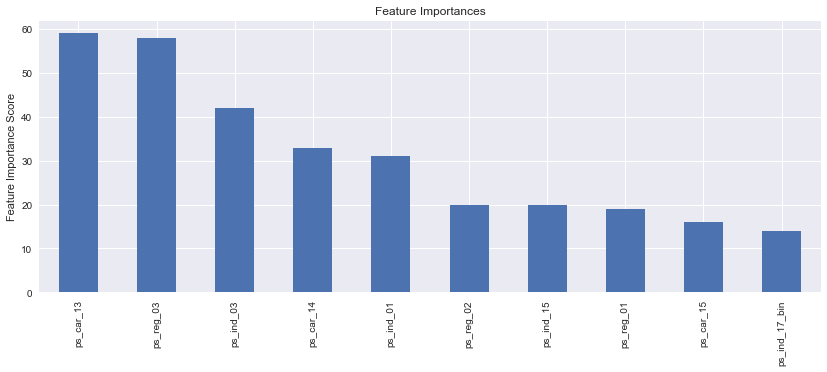

In [25]:
clf7 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.3,       # let's get it a bit higher so we can get results faster
    n_estimators = 1000,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0.3,
    min_child_weight=5,
    max_delta_step = 0,
    subsample = 0.9,
    colsample_bytree = 0.8,
    colsample_bylevel = 1,
    reg_alpha = 13,
    reg_lambda = 0.2,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf7, x_train_enc, y_train)

[0]	train-auc:0.560517+0.00799272	test-auc:0.557598+0.00757127
[1]	train-auc:0.575828+0.00582662	test-auc:0.572498+0.00682702
[2]	train-auc:0.576837+0.00663354	test-auc:0.573807+0.00995045
[3]	train-auc:0.584497+0.00690709	test-auc:0.581714+0.0125291
[4]	train-auc:0.584626+0.00622408	test-auc:0.582303+0.0112307
[5]	train-auc:0.585795+0.00676036	test-auc:0.583122+0.011907
[6]	train-auc:0.586514+0.00684214	test-auc:0.583996+0.0117576
[7]	train-auc:0.588277+0.00474441	test-auc:0.58575+0.00925787
[8]	train-auc:0.590007+0.00433332	test-auc:0.587511+0.00703425
[9]	train-auc:0.594032+0.00756374	test-auc:0.591481+0.00781217
[10]	train-auc:0.595875+0.00491642	test-auc:0.593059+0.00721432
[11]	train-auc:0.596337+0.00533753	test-auc:0.59336+0.00749892
[12]	train-auc:0.598293+0.0054321	test-auc:0.594998+0.00901897
[13]	train-auc:0.598359+0.00548897	test-auc:0.595129+0.00876616
[14]	train-auc:0.598148+0.00524889	test-auc:0.59508+0.0085266
[15]	train-auc:0.598232+0.00534621	test-auc:0.59514+0.008437

[129]	train-auc:0.613991+0.00166369	test-auc:0.610856+0.00494026
[130]	train-auc:0.614211+0.00146051	test-auc:0.611022+0.00491722
[131]	train-auc:0.614454+0.00147888	test-auc:0.611157+0.00487167
[132]	train-auc:0.61464+0.00161032	test-auc:0.611312+0.00473766
[133]	train-auc:0.614682+0.00157502	test-auc:0.611342+0.0047423
[134]	train-auc:0.614715+0.00161258	test-auc:0.611399+0.00473299
[135]	train-auc:0.614824+0.00159009	test-auc:0.611474+0.00473215
[136]	train-auc:0.614875+0.00163024	test-auc:0.611519+0.00474046
[137]	train-auc:0.614976+0.00153576	test-auc:0.611638+0.00471456
[138]	train-auc:0.615113+0.00153011	test-auc:0.61178+0.00469271
[139]	train-auc:0.61519+0.00156644	test-auc:0.611843+0.00465007
[140]	train-auc:0.615237+0.00155507	test-auc:0.611908+0.00466148
[141]	train-auc:0.615393+0.00155612	test-auc:0.612096+0.0046288
[142]	train-auc:0.615442+0.00155094	test-auc:0.61219+0.00459995
[143]	train-auc:0.61551+0.00158844	test-auc:0.61226+0.00461438
[144]	train-auc:0.615594+0.001580

[257]	train-auc:0.622759+0.00120082	test-auc:0.618699+0.00524088
[258]	train-auc:0.622831+0.00115568	test-auc:0.618766+0.00527806
[259]	train-auc:0.622893+0.00114953	test-auc:0.618831+0.00523956
[260]	train-auc:0.622978+0.00112417	test-auc:0.618877+0.00526443
[261]	train-auc:0.623089+0.00113161	test-auc:0.618945+0.00523679
[262]	train-auc:0.623137+0.00109673	test-auc:0.618996+0.00529736
[263]	train-auc:0.623255+0.00109017	test-auc:0.619102+0.00530025
[264]	train-auc:0.623319+0.00113264	test-auc:0.619144+0.0052557
[265]	train-auc:0.62337+0.00113769	test-auc:0.619188+0.00525309
[266]	train-auc:0.623414+0.00115839	test-auc:0.619207+0.00522526
[267]	train-auc:0.623508+0.00114455	test-auc:0.619287+0.0052189
[268]	train-auc:0.623568+0.00114237	test-auc:0.619362+0.00518689
[269]	train-auc:0.623603+0.00115281	test-auc:0.619389+0.0051858
[270]	train-auc:0.623694+0.00113543	test-auc:0.619455+0.00518923
[271]	train-auc:0.623761+0.00115723	test-auc:0.619526+0.00516622
[272]	train-auc:0.623852+0.00

[384]	train-auc:0.631983+0.00131887	test-auc:0.62575+0.00525191
[385]	train-auc:0.632055+0.00129689	test-auc:0.6258+0.00528011
[386]	train-auc:0.632108+0.00130078	test-auc:0.625865+0.00529019
[387]	train-auc:0.632176+0.00130938	test-auc:0.625911+0.00527037
[388]	train-auc:0.632237+0.0013091	test-auc:0.625961+0.00526656
[389]	train-auc:0.632312+0.00131111	test-auc:0.626025+0.005286
[390]	train-auc:0.63237+0.00130885	test-auc:0.626061+0.00527474
[391]	train-auc:0.632466+0.00131603	test-auc:0.626128+0.00526545
[392]	train-auc:0.632522+0.00130176	test-auc:0.626163+0.00528988
[393]	train-auc:0.63257+0.00130046	test-auc:0.626202+0.0052867
[394]	train-auc:0.632588+0.00131455	test-auc:0.626207+0.00528735
[395]	train-auc:0.632627+0.00129861	test-auc:0.62624+0.00528242
[396]	train-auc:0.632697+0.0012972	test-auc:0.626318+0.00527055
[397]	train-auc:0.632759+0.00131289	test-auc:0.626363+0.00525943
[398]	train-auc:0.632794+0.00132526	test-auc:0.626378+0.0052359
[399]	train-auc:0.63286+0.00133452	te

[512]	train-auc:0.6385+0.0012981	test-auc:0.630966+0.0054557
[513]	train-auc:0.638549+0.00130226	test-auc:0.631006+0.0054702
[514]	train-auc:0.638588+0.00130368	test-auc:0.631038+0.00545234
[515]	train-auc:0.638633+0.00131062	test-auc:0.631076+0.00543958
[516]	train-auc:0.638676+0.00130784	test-auc:0.631116+0.00542531
[517]	train-auc:0.638715+0.00130794	test-auc:0.631164+0.00543878
[518]	train-auc:0.638756+0.00131134	test-auc:0.6312+0.0054262
[519]	train-auc:0.638799+0.00131549	test-auc:0.631235+0.00542265
[520]	train-auc:0.638841+0.0013137	test-auc:0.631269+0.00541187
[521]	train-auc:0.638891+0.00130207	test-auc:0.631304+0.00540953
[522]	train-auc:0.638918+0.00130005	test-auc:0.631333+0.00540425
[523]	train-auc:0.638956+0.00130057	test-auc:0.631361+0.0053996
[524]	train-auc:0.638995+0.00130808	test-auc:0.631398+0.00537763
[525]	train-auc:0.639027+0.00131245	test-auc:0.631432+0.00537904
[526]	train-auc:0.639065+0.00130857	test-auc:0.631465+0.00536989
[527]	train-auc:0.639097+0.00130527

[639]	train-auc:0.642634+0.00143619	test-auc:0.634317+0.00530666
[640]	train-auc:0.642655+0.00144662	test-auc:0.634333+0.00530265
[641]	train-auc:0.642686+0.00143966	test-auc:0.634354+0.00530806
[642]	train-auc:0.642733+0.00142662	test-auc:0.634399+0.00532155
[643]	train-auc:0.642755+0.00142618	test-auc:0.634411+0.00531775
[644]	train-auc:0.642786+0.0014183	test-auc:0.634438+0.0053393
[645]	train-auc:0.642819+0.00143036	test-auc:0.634468+0.00533651
[646]	train-auc:0.642848+0.00143257	test-auc:0.634484+0.00533254
[647]	train-auc:0.642867+0.00142095	test-auc:0.634504+0.00533751
[648]	train-auc:0.642892+0.00142435	test-auc:0.634518+0.00532965
[649]	train-auc:0.642937+0.0014144	test-auc:0.634552+0.00533337
[650]	train-auc:0.64295+0.00141353	test-auc:0.634565+0.00534092
[651]	train-auc:0.642964+0.00140954	test-auc:0.634578+0.00534832
[652]	train-auc:0.64299+0.00140664	test-auc:0.634594+0.00534935
[653]	train-auc:0.643014+0.00140588	test-auc:0.634608+0.00535743
[654]	train-auc:0.643036+0.001

[766]	train-auc:0.645552+0.00138741	test-auc:0.63653+0.0055075
[767]	train-auc:0.645573+0.00139227	test-auc:0.636541+0.00550722
[768]	train-auc:0.645587+0.00139504	test-auc:0.636547+0.00550551
[769]	train-auc:0.645608+0.0014016	test-auc:0.63656+0.00549382
[770]	train-auc:0.645634+0.00140691	test-auc:0.63658+0.00548681
[771]	train-auc:0.645656+0.00140297	test-auc:0.636594+0.00548986
[772]	train-auc:0.645673+0.0014065	test-auc:0.636612+0.00548742
[773]	train-auc:0.645694+0.00140274	test-auc:0.636622+0.00549884
[774]	train-auc:0.645716+0.00139893	test-auc:0.636631+0.00550256
[775]	train-auc:0.645733+0.00140058	test-auc:0.636637+0.00550261
[776]	train-auc:0.645751+0.00140275	test-auc:0.636643+0.00550075
[777]	train-auc:0.645772+0.00140346	test-auc:0.63665+0.00550336
[778]	train-auc:0.645789+0.00140415	test-auc:0.636661+0.00550264
[779]	train-auc:0.645806+0.00139979	test-auc:0.636676+0.00550847
[780]	train-auc:0.645826+0.00139773	test-auc:0.63669+0.00550596
[781]	train-auc:0.645846+0.001400

[893]	train-auc:0.647827+0.00140022	test-auc:0.637877+0.00561485
[894]	train-auc:0.647842+0.00140433	test-auc:0.637895+0.00561645
[895]	train-auc:0.647856+0.00140762	test-auc:0.637907+0.00561666
[896]	train-auc:0.647871+0.00140495	test-auc:0.63791+0.00561311
[897]	train-auc:0.647892+0.00141366	test-auc:0.637932+0.00560095
[898]	train-auc:0.647907+0.00141434	test-auc:0.637948+0.00559859
[899]	train-auc:0.647929+0.00141632	test-auc:0.637968+0.00559706
[900]	train-auc:0.647944+0.00141729	test-auc:0.637973+0.00559572
[901]	train-auc:0.647955+0.00141608	test-auc:0.637974+0.00560136
[902]	train-auc:0.647973+0.00141896	test-auc:0.637984+0.00560521
[903]	train-auc:0.64799+0.00142182	test-auc:0.637992+0.00560043
[904]	train-auc:0.648008+0.00143364	test-auc:0.638008+0.00558967
[905]	train-auc:0.648028+0.00143882	test-auc:0.638022+0.00557564
[906]	train-auc:0.648039+0.00144172	test-auc:0.638035+0.00557246
[907]	train-auc:0.648054+0.0014431	test-auc:0.638041+0.00557624
[908]	train-auc:0.648072+0.0

[1020]	train-auc:0.649743+0.00143976	test-auc:0.63882+0.00568184
[1021]	train-auc:0.649758+0.00144023	test-auc:0.638819+0.00569085
[1022]	train-auc:0.649778+0.00143567	test-auc:0.638825+0.00569584
[1023]	train-auc:0.649793+0.00143317	test-auc:0.638832+0.0056991
[1024]	train-auc:0.649806+0.00143335	test-auc:0.638836+0.00569899
[1025]	train-auc:0.649824+0.00143275	test-auc:0.638842+0.00569183
[1026]	train-auc:0.64984+0.00143228	test-auc:0.638847+0.00569847
[1027]	train-auc:0.649853+0.00143325	test-auc:0.63885+0.00569521
[1028]	train-auc:0.649866+0.00143433	test-auc:0.63885+0.00569723
[1029]	train-auc:0.64988+0.0014304	test-auc:0.638854+0.00570019
[1030]	train-auc:0.649895+0.00143129	test-auc:0.638861+0.0057038
[1031]	train-auc:0.649914+0.00143187	test-auc:0.638873+0.00570089
[1032]	train-auc:0.649927+0.00142861	test-auc:0.638871+0.00570515
[1033]	train-auc:0.649941+0.00142627	test-auc:0.638881+0.00571168
[1034]	train-auc:0.649957+0.00142718	test-auc:0.638886+0.00571133
[1035]	train-auc:0

[1146]	train-auc:0.65151+0.00144876	test-auc:0.639516+0.00573003
[1147]	train-auc:0.651525+0.00144853	test-auc:0.639524+0.00572713
[1148]	train-auc:0.65154+0.00145026	test-auc:0.639529+0.00573231
[1149]	train-auc:0.651551+0.00145185	test-auc:0.639531+0.00572935
[1150]	train-auc:0.651565+0.00144909	test-auc:0.639532+0.00572622
[1151]	train-auc:0.651579+0.00144929	test-auc:0.639538+0.00573042
[1152]	train-auc:0.651591+0.00144934	test-auc:0.63954+0.00573347
[1153]	train-auc:0.651605+0.00144845	test-auc:0.639545+0.00573342
[1154]	train-auc:0.651612+0.00144774	test-auc:0.639549+0.00573663
[1155]	train-auc:0.651624+0.00144836	test-auc:0.639553+0.0057363
[1156]	train-auc:0.651638+0.00145021	test-auc:0.639554+0.0057358
[1157]	train-auc:0.65165+0.00144692	test-auc:0.639555+0.00573597
[1158]	train-auc:0.651665+0.00144386	test-auc:0.639563+0.00573944
[1159]	train-auc:0.651677+0.00144391	test-auc:0.639559+0.00574406
[1160]	train-auc:0.65169+0.0014419	test-auc:0.639566+0.00574417
[1161]	train-auc:0

[1272]	train-auc:0.653086+0.00142567	test-auc:0.640006+0.00578288
[1273]	train-auc:0.653096+0.00142686	test-auc:0.640011+0.00578359
[1274]	train-auc:0.653107+0.00142753	test-auc:0.640009+0.00578448
[1275]	train-auc:0.65312+0.00143062	test-auc:0.640013+0.00578363
[1276]	train-auc:0.653132+0.00143192	test-auc:0.640017+0.00578235
[1277]	train-auc:0.65314+0.00143211	test-auc:0.64002+0.00578255
[1278]	train-auc:0.653153+0.00143279	test-auc:0.640022+0.00577648
[1279]	train-auc:0.653164+0.00143502	test-auc:0.640026+0.00577383
[1280]	train-auc:0.653177+0.00143789	test-auc:0.640032+0.00577257
[1281]	train-auc:0.653194+0.00144028	test-auc:0.640035+0.00577156
[1282]	train-auc:0.65321+0.00144305	test-auc:0.640041+0.00576718
[1283]	train-auc:0.653223+0.00144406	test-auc:0.640042+0.00576685
[1284]	train-auc:0.653235+0.00144452	test-auc:0.640042+0.00576706
[1285]	train-auc:0.653248+0.00144148	test-auc:0.640048+0.00576695
[1286]	train-auc:0.653259+0.00144069	test-auc:0.64005+0.00576633
[1287]	train-au

[1397]	train-auc:0.654555+0.0014213	test-auc:0.640401+0.00577262
[1398]	train-auc:0.654566+0.00142212	test-auc:0.640401+0.00577297
[1399]	train-auc:0.654577+0.00142282	test-auc:0.640406+0.00577597
[1400]	train-auc:0.654588+0.00142372	test-auc:0.640409+0.00577457
[1401]	train-auc:0.6546+0.00142635	test-auc:0.64041+0.00577882
[1402]	train-auc:0.654611+0.00142518	test-auc:0.640415+0.00577716
[1403]	train-auc:0.654623+0.00142484	test-auc:0.64042+0.00577991
[1404]	train-auc:0.654637+0.00142792	test-auc:0.640428+0.00577914
[1405]	train-auc:0.654649+0.00142545	test-auc:0.640432+0.00578272
[1406]	train-auc:0.654661+0.00142194	test-auc:0.640435+0.00578265
[1407]	train-auc:0.65467+0.00142324	test-auc:0.640438+0.00577744
[1408]	train-auc:0.654685+0.00142248	test-auc:0.640444+0.00578303
[1409]	train-auc:0.6547+0.00142341	test-auc:0.640455+0.00578487
[1410]	train-auc:0.654713+0.00142417	test-auc:0.640454+0.0057887
[1411]	train-auc:0.654723+0.00142413	test-auc:0.640456+0.00579081
[1412]	train-auc:0.

[1523]	train-auc:0.655928+0.00143488	test-auc:0.640755+0.0058423
[1524]	train-auc:0.655939+0.00143388	test-auc:0.640759+0.00584159
[1525]	train-auc:0.655952+0.00143449	test-auc:0.640762+0.0058427
[1526]	train-auc:0.655964+0.00143754	test-auc:0.640764+0.00584089
[1527]	train-auc:0.655975+0.00143874	test-auc:0.640768+0.00583901
[1528]	train-auc:0.655986+0.00144141	test-auc:0.64077+0.00583898
[1529]	train-auc:0.655997+0.00143944	test-auc:0.640772+0.00584066
[1530]	train-auc:0.656008+0.00143692	test-auc:0.640773+0.00584244
[1531]	train-auc:0.656016+0.00143736	test-auc:0.640776+0.0058431
[1532]	train-auc:0.656027+0.00143876	test-auc:0.640778+0.00584568
[1533]	train-auc:0.656039+0.00143852	test-auc:0.640782+0.00584581
[1534]	train-auc:0.65605+0.00143971	test-auc:0.64078+0.00584371
[1535]	train-auc:0.65606+0.00144063	test-auc:0.640785+0.00584652
[1536]	train-auc:0.65607+0.00143895	test-auc:0.640791+0.00584821
[1537]	train-auc:0.656083+0.00143914	test-auc:0.640797+0.00584572
[1538]	train-auc:0

[1649]	train-auc:0.657232+0.00142414	test-auc:0.641062+0.0058642
[1650]	train-auc:0.657246+0.00142358	test-auc:0.641061+0.00586667
[1651]	train-auc:0.657256+0.00142325	test-auc:0.641062+0.00586755
[1652]	train-auc:0.657266+0.00142059	test-auc:0.641066+0.00587485
[1653]	train-auc:0.657276+0.00142024	test-auc:0.641067+0.00587783
[1654]	train-auc:0.657285+0.00142279	test-auc:0.641067+0.00588196
[1655]	train-auc:0.657293+0.00142304	test-auc:0.641068+0.00588641
[1656]	train-auc:0.657306+0.0014173	test-auc:0.641075+0.00588718
[1657]	train-auc:0.657314+0.00141644	test-auc:0.641079+0.00588675
[1658]	train-auc:0.657328+0.00141364	test-auc:0.641086+0.00589106
[1659]	train-auc:0.657339+0.00141427	test-auc:0.641086+0.00588739
[1660]	train-auc:0.657348+0.00141315	test-auc:0.641085+0.00588889
[1661]	train-auc:0.65736+0.00141283	test-auc:0.641091+0.00589211
[1662]	train-auc:0.657368+0.00141397	test-auc:0.641089+0.00588796
[1663]	train-auc:0.657379+0.00141262	test-auc:0.641091+0.00588626
[1664]	train-

[1774]	train-auc:0.65848+0.00136921	test-auc:0.641342+0.00590608
[1775]	train-auc:0.658494+0.0013678	test-auc:0.641346+0.00590709
[1776]	train-auc:0.658504+0.00136621	test-auc:0.641351+0.0059103
[1777]	train-auc:0.658515+0.00136701	test-auc:0.641358+0.00591172
[1778]	train-auc:0.658528+0.00137294	test-auc:0.641361+0.00590848
[1779]	train-auc:0.65854+0.00137526	test-auc:0.641365+0.0059053
[1780]	train-auc:0.658549+0.00137662	test-auc:0.641364+0.005907
[1781]	train-auc:0.658559+0.00137464	test-auc:0.641368+0.00591151
[1782]	train-auc:0.658572+0.0013735	test-auc:0.641373+0.00591122
[1783]	train-auc:0.658582+0.00137229	test-auc:0.641372+0.0059146
[1784]	train-auc:0.658588+0.00137072	test-auc:0.641373+0.00591811
[1785]	train-auc:0.658597+0.00136857	test-auc:0.641375+0.00591669
[1786]	train-auc:0.658609+0.00136533	test-auc:0.641378+0.00591952
[1787]	train-auc:0.658616+0.00136363	test-auc:0.641383+0.00592026
[1788]	train-auc:0.658625+0.00136301	test-auc:0.641384+0.0059202
[1789]	train-auc:0.6

[1900]	train-auc:0.659722+0.00134752	test-auc:0.6416+0.00595486
[1901]	train-auc:0.659732+0.00134857	test-auc:0.641604+0.00595631
[1902]	train-auc:0.65974+0.00134809	test-auc:0.641606+0.00595779
[1903]	train-auc:0.659746+0.00134805	test-auc:0.641601+0.00595724
[1904]	train-auc:0.659758+0.00134687	test-auc:0.641601+0.00595672
[1905]	train-auc:0.659768+0.00134654	test-auc:0.641599+0.00595423
[1906]	train-auc:0.659775+0.00134429	test-auc:0.641597+0.0059548
[1907]	train-auc:0.659783+0.00134287	test-auc:0.641598+0.00595438
[1908]	train-auc:0.659792+0.0013433	test-auc:0.6416+0.00595373
[1909]	train-auc:0.6598+0.00134459	test-auc:0.641606+0.005951
[1910]	train-auc:0.659811+0.00134519	test-auc:0.641607+0.00595416
[1911]	train-auc:0.659823+0.00134416	test-auc:0.641611+0.00595447
[1912]	train-auc:0.659833+0.00134683	test-auc:0.641613+0.00595533
[1913]	train-auc:0.659842+0.00134754	test-auc:0.641617+0.0059561
[1914]	train-auc:0.65985+0.00134697	test-auc:0.641619+0.00595924
[1915]	train-auc:0.6598

[2026]	train-auc:0.660883+0.00133022	test-auc:0.641803+0.00595922
[2027]	train-auc:0.660893+0.0013274	test-auc:0.641808+0.00595747
[2028]	train-auc:0.6609+0.00132699	test-auc:0.641808+0.00595622
[2029]	train-auc:0.660911+0.00132698	test-auc:0.64181+0.00595921
[2030]	train-auc:0.660922+0.00132796	test-auc:0.641812+0.00595959
[2031]	train-auc:0.660931+0.00132661	test-auc:0.641813+0.00596219
[2032]	train-auc:0.660945+0.00133081	test-auc:0.64182+0.00595535
[2033]	train-auc:0.660953+0.0013327	test-auc:0.641827+0.00595273
[2034]	train-auc:0.66096+0.00133202	test-auc:0.641826+0.00595047
[2035]	train-auc:0.660971+0.00133217	test-auc:0.641825+0.00595294
[2036]	train-auc:0.66098+0.00133211	test-auc:0.641825+0.00595529
[2037]	train-auc:0.660992+0.00133219	test-auc:0.641831+0.00595825
[2038]	train-auc:0.661001+0.00133271	test-auc:0.641833+0.00595994
[2039]	train-auc:0.661008+0.0013345	test-auc:0.641835+0.00595537
[2040]	train-auc:0.66102+0.0013331	test-auc:0.641839+0.00595391
[2041]	train-auc:0.66

[2152]	train-auc:0.662037+0.00133857	test-auc:0.641974+0.0059587
[2153]	train-auc:0.662046+0.00134104	test-auc:0.641974+0.00595896
[2154]	train-auc:0.662053+0.00133947	test-auc:0.641974+0.00596145
[2155]	train-auc:0.662062+0.00134163	test-auc:0.641975+0.00595991
[2156]	train-auc:0.66207+0.00134306	test-auc:0.641975+0.00596
[2157]	train-auc:0.662079+0.00134429	test-auc:0.64198+0.00596341
[2158]	train-auc:0.662085+0.00134516	test-auc:0.641981+0.00596123
[2159]	train-auc:0.662091+0.00134575	test-auc:0.64198+0.00596376
[2160]	train-auc:0.662101+0.00134823	test-auc:0.64198+0.00596316
[2161]	train-auc:0.662109+0.00135021	test-auc:0.641977+0.00596477
[2162]	train-auc:0.662118+0.0013491	test-auc:0.64198+0.00596437
[2163]	train-auc:0.662127+0.00134727	test-auc:0.64198+0.00596446
[2164]	train-auc:0.662135+0.00134597	test-auc:0.641981+0.00596337
[2165]	train-auc:0.662145+0.00134584	test-auc:0.641984+0.00596298
[2166]	train-auc:0.662153+0.00134328	test-auc:0.641988+0.0059664
[2167]	train-auc:0.662

[2278]	train-auc:0.663156+0.00133799	test-auc:0.642111+0.00598098
[2279]	train-auc:0.663164+0.00133735	test-auc:0.64211+0.00597859
[2280]	train-auc:0.663171+0.00133995	test-auc:0.642111+0.00597972
[2281]	train-auc:0.663178+0.00134104	test-auc:0.642108+0.00598109
[2282]	train-auc:0.663186+0.00134125	test-auc:0.642105+0.00597652
[2283]	train-auc:0.663194+0.00134221	test-auc:0.642105+0.00597938
[2284]	train-auc:0.663205+0.00134198	test-auc:0.642102+0.00597888
[2285]	train-auc:0.663214+0.00134316	test-auc:0.642104+0.00597585
[2286]	train-auc:0.663224+0.00133932	test-auc:0.642105+0.00597552
[2287]	train-auc:0.663232+0.00133782	test-auc:0.642105+0.00597417
[2288]	train-auc:0.663242+0.00133663	test-auc:0.642107+0.00597647
[2289]	train-auc:0.66325+0.00133865	test-auc:0.642108+0.00597777
[2290]	train-auc:0.663258+0.0013383	test-auc:0.642111+0.00598223
[2291]	train-auc:0.663267+0.00133891	test-auc:0.642112+0.0059802
[2292]	train-auc:0.663274+0.0013379	test-auc:0.642109+0.00597622
[2293]	train-au

[2403]	train-auc:0.664201+0.00133884	test-auc:0.642197+0.00596822
[2404]	train-auc:0.664209+0.00133644	test-auc:0.642199+0.00596372
[2405]	train-auc:0.664221+0.00133505	test-auc:0.642195+0.0059605
[2406]	train-auc:0.664227+0.00133654	test-auc:0.642192+0.00595891
[2407]	train-auc:0.664235+0.00133778	test-auc:0.642193+0.00595688
[2408]	train-auc:0.664243+0.00133695	test-auc:0.642191+0.00595859
[2409]	train-auc:0.664252+0.00133515	test-auc:0.642195+0.00596208
[2410]	train-auc:0.664259+0.00133752	test-auc:0.642195+0.00596203
[2411]	train-auc:0.664268+0.00133667	test-auc:0.642194+0.00596347
[2412]	train-auc:0.664276+0.00133584	test-auc:0.642196+0.00596634
[2413]	train-auc:0.664286+0.00133588	test-auc:0.642199+0.00596626
[2414]	train-auc:0.664293+0.00133595	test-auc:0.6422+0.00596621
[2415]	train-auc:0.664301+0.00133829	test-auc:0.642203+0.00596763
[2416]	train-auc:0.664308+0.00133927	test-auc:0.642206+0.00596681
[2417]	train-auc:0.664314+0.00134049	test-auc:0.642205+0.00596768
[2418]	train-

[2528]	train-auc:0.665256+0.0013489	test-auc:0.642307+0.00594305
[2529]	train-auc:0.665264+0.00134904	test-auc:0.642309+0.00594849
[2530]	train-auc:0.665273+0.0013495	test-auc:0.642312+0.0059445
[2531]	train-auc:0.665281+0.00135116	test-auc:0.642311+0.00594106
[2532]	train-auc:0.665288+0.00135176	test-auc:0.64231+0.00594355
[2533]	train-auc:0.665294+0.00135335	test-auc:0.64231+0.00594303
[2534]	train-auc:0.665303+0.00135116	test-auc:0.642307+0.0059411
[2535]	train-auc:0.665313+0.00135096	test-auc:0.64231+0.00594358
[2536]	train-auc:0.665322+0.00135089	test-auc:0.64231+0.00594345
[2537]	train-auc:0.665332+0.00135157	test-auc:0.642303+0.00593994
[2538]	train-auc:0.66534+0.00135209	test-auc:0.642301+0.00594113
[2539]	train-auc:0.665351+0.00135387	test-auc:0.642305+0.00593923
[2540]	train-auc:0.665362+0.00135579	test-auc:0.642303+0.00593812
[2541]	train-auc:0.66537+0.00135414	test-auc:0.642307+0.00593907
[2542]	train-auc:0.66538+0.0013519	test-auc:0.642311+0.00593764
[2543]	train-auc:0.665

[2653]	train-auc:0.666302+0.00135156	test-auc:0.642395+0.00593644
[2654]	train-auc:0.666311+0.00134973	test-auc:0.642396+0.00593671
[2655]	train-auc:0.666319+0.0013529	test-auc:0.642398+0.0059345
[2656]	train-auc:0.666327+0.00135498	test-auc:0.642398+0.00593265
[2657]	train-auc:0.666333+0.00135484	test-auc:0.642399+0.00593154
[2658]	train-auc:0.666341+0.00135211	test-auc:0.642398+0.00593253
[2659]	train-auc:0.666352+0.00135289	test-auc:0.642396+0.00593595
[2660]	train-auc:0.666359+0.00135113	test-auc:0.642398+0.00593619
[2661]	train-auc:0.666366+0.00134987	test-auc:0.642399+0.00593744
[2662]	train-auc:0.666371+0.00134982	test-auc:0.642399+0.00593937
[2663]	train-auc:0.666378+0.0013498	test-auc:0.6424+0.00593455
[2664]	train-auc:0.666387+0.00134808	test-auc:0.642396+0.00593592
[2665]	train-auc:0.666396+0.00134763	test-auc:0.642395+0.00593298
[2666]	train-auc:0.666408+0.00134921	test-auc:0.642394+0.00593343
[2667]	train-auc:0.666418+0.00135165	test-auc:0.6424+0.00593049
[2668]	train-auc:

[2778]	train-auc:0.667315+0.00133847	test-auc:0.642468+0.0059233
[2779]	train-auc:0.667325+0.00134145	test-auc:0.642466+0.00592373
[2780]	train-auc:0.667333+0.00134006	test-auc:0.642466+0.00592554
[2781]	train-auc:0.667342+0.00133845	test-auc:0.642467+0.00592458
[2782]	train-auc:0.667349+0.00133958	test-auc:0.642465+0.00592525
[2783]	train-auc:0.667358+0.00133926	test-auc:0.642462+0.00592523
[2784]	train-auc:0.667366+0.00133608	test-auc:0.642465+0.00592795
[2785]	train-auc:0.667373+0.00133377	test-auc:0.642465+0.0059263
[2786]	train-auc:0.667381+0.00133551	test-auc:0.642463+0.00592805
[2787]	train-auc:0.667389+0.00133664	test-auc:0.642465+0.00592471
[2788]	train-auc:0.667399+0.00133448	test-auc:0.642467+0.00592661
[2789]	train-auc:0.667407+0.00133427	test-auc:0.642468+0.00592624
[2790]	train-auc:0.667414+0.00133433	test-auc:0.642468+0.00592566
[2791]	train-auc:0.66742+0.00133472	test-auc:0.642466+0.00592462
[2792]	train-auc:0.667426+0.00133417	test-auc:0.642466+0.0059251
[2793]	train-a

[2903]	train-auc:0.668285+0.00132094	test-auc:0.642527+0.00592834
[2904]	train-auc:0.668293+0.00132072	test-auc:0.642529+0.00592742
[2905]	train-auc:0.668302+0.00132101	test-auc:0.64253+0.00592416
[2906]	train-auc:0.668309+0.00132082	test-auc:0.642532+0.00592375
[2907]	train-auc:0.66832+0.00132069	test-auc:0.642534+0.00592475
[2908]	train-auc:0.668328+0.00132188	test-auc:0.642536+0.00592599
[2909]	train-auc:0.668336+0.00132361	test-auc:0.642533+0.00592863
[2910]	train-auc:0.668346+0.00132365	test-auc:0.64253+0.00592542
[2911]	train-auc:0.668356+0.0013234	test-auc:0.642532+0.00592735
[2912]	train-auc:0.668365+0.00132363	test-auc:0.642531+0.00593257
[2913]	train-auc:0.668372+0.00132328	test-auc:0.64253+0.00593113
[2914]	train-auc:0.668378+0.00132314	test-auc:0.642532+0.00593144
[2915]	train-auc:0.668388+0.00132011	test-auc:0.642533+0.00592748
[2916]	train-auc:0.668395+0.00131812	test-auc:0.642533+0.00592762
[2917]	train-auc:0.668401+0.00131972	test-auc:0.642532+0.00592721
[2918]	train-au

[3028]	train-auc:0.669236+0.00133036	test-auc:0.642573+0.00595126
[3029]	train-auc:0.669244+0.00132998	test-auc:0.642575+0.00595117
[3030]	train-auc:0.66925+0.00132878	test-auc:0.642574+0.0059515
[3031]	train-auc:0.669256+0.00132825	test-auc:0.642574+0.00595343
[3032]	train-auc:0.669264+0.00132827	test-auc:0.642572+0.00595506
[3033]	train-auc:0.669272+0.00132761	test-auc:0.642571+0.00595279
[3034]	train-auc:0.669281+0.00132763	test-auc:0.642568+0.00595156
[3035]	train-auc:0.669288+0.00132855	test-auc:0.64257+0.00595074
[3036]	train-auc:0.669297+0.00132859	test-auc:0.64257+0.00595096
[3037]	train-auc:0.669302+0.00132847	test-auc:0.64257+0.00595273
[3038]	train-auc:0.669309+0.00132853	test-auc:0.642569+0.00595584
[3039]	train-auc:0.669319+0.00133028	test-auc:0.64257+0.00595288
[3040]	train-auc:0.669323+0.00132904	test-auc:0.642571+0.00595059
[3041]	train-auc:0.669332+0.00132967	test-auc:0.642571+0.00595218
[3042]	train-auc:0.669338+0.00132864	test-auc:0.642572+0.00595115
[3043]	train-auc

[3154]	train-auc:0.670194+0.0013074	test-auc:0.642623+0.00593522
[3155]	train-auc:0.670203+0.00130756	test-auc:0.642621+0.00593884
[3156]	train-auc:0.670211+0.00130683	test-auc:0.642626+0.00593663
[3157]	train-auc:0.670219+0.00130713	test-auc:0.642627+0.00593397
[3158]	train-auc:0.670224+0.00130541	test-auc:0.642625+0.00593428
[3159]	train-auc:0.670233+0.00130376	test-auc:0.642627+0.00593459
[3160]	train-auc:0.670242+0.00130335	test-auc:0.642625+0.00593571
[3161]	train-auc:0.670249+0.0013029	test-auc:0.642624+0.00593728
[3162]	train-auc:0.670258+0.00130386	test-auc:0.642625+0.00593621
[3163]	train-auc:0.670265+0.00130297	test-auc:0.642622+0.0059311
[3164]	train-auc:0.670272+0.00130383	test-auc:0.642621+0.00593161
[3165]	train-auc:0.670279+0.00130294	test-auc:0.642621+0.00593497
[3166]	train-auc:0.670287+0.00130459	test-auc:0.642622+0.00593462
[3167]	train-auc:0.670294+0.00130334	test-auc:0.642622+0.005938
[3168]	train-auc:0.6703+0.00130293	test-auc:0.642621+0.00593614
[3169]	train-auc:

[3279]	train-auc:0.671129+0.00130086	test-auc:0.642652+0.00595683
[3280]	train-auc:0.671137+0.00129907	test-auc:0.642651+0.00596029
[3281]	train-auc:0.671144+0.00130121	test-auc:0.642653+0.00595529
[3282]	train-auc:0.671154+0.00130377	test-auc:0.642654+0.00595535
[3283]	train-auc:0.671161+0.00130444	test-auc:0.642653+0.00595402
[3284]	train-auc:0.67117+0.00130029	test-auc:0.642656+0.00595938
[3285]	train-auc:0.671177+0.00129841	test-auc:0.642656+0.00595721
[3286]	train-auc:0.671184+0.00130035	test-auc:0.642656+0.00595586
[3287]	train-auc:0.671191+0.00129967	test-auc:0.642659+0.00595724
[3288]	train-auc:0.671199+0.00129767	test-auc:0.642661+0.00595859
[3289]	train-auc:0.671205+0.00129726	test-auc:0.642665+0.00595573
[3290]	train-auc:0.671212+0.00129632	test-auc:0.642668+0.00595605
[3291]	train-auc:0.671218+0.00129752	test-auc:0.642666+0.00595911
[3292]	train-auc:0.671221+0.00129685	test-auc:0.642667+0.00595848
[3293]	train-auc:0.671229+0.00129533	test-auc:0.642664+0.00596009
[3294]	trai

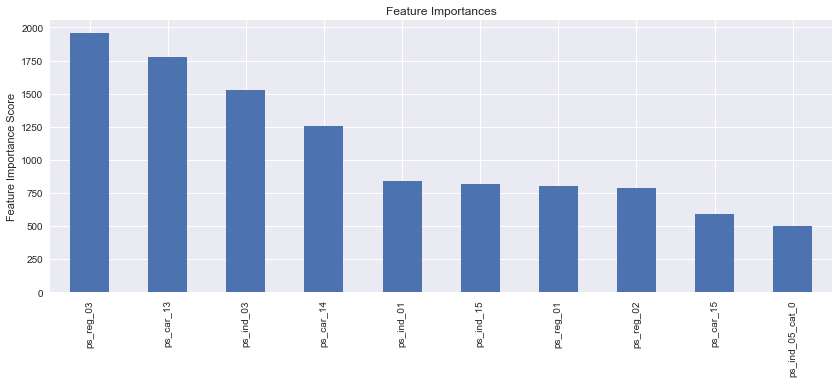

In [26]:
clf8 = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.01,       # let's get it a bit higher so we can get results faster
    n_estimators = 5000,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0.3,
    min_child_weight=5,
    max_delta_step = 0,
    subsample = 0.9,
    colsample_bytree = 0.8,
    colsample_bylevel = 1,
    reg_alpha = 13,
    reg_lambda = 0.2,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(clf8, x_train_enc, y_train)

In [29]:
index_class_true = clf8.classes_[clf8.classes_ == 1]
predictions_test_enc_8 = clf8.predict_proba(x_test_enc)[:, index_class_true]
print("Test score: {0:.5f}".format(roc_auc_score(y_test, predictions_test_enc_8)))

Test score: 0.63195


Train score: 0.66794


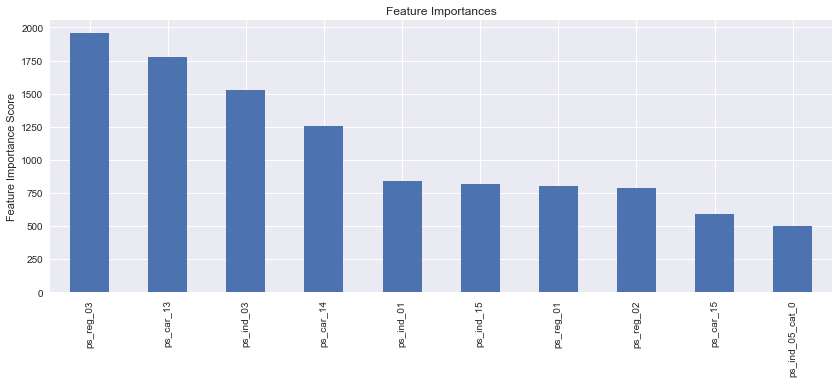

Test score: 0.63195


In [25]:
final_model = xgboost.XGBClassifier(
    max_depth = 3,
    learning_rate = 0.01,       # let's get it a bit higher so we can get results faster
    n_estimators = 3291,       # CV (in method above) will find best number
    silent = False,
    n_jobs = 4,                
    gamma = 0.3,
    min_child_weight=5,
    max_delta_step = 0,
    subsample = 0.9,
    colsample_bytree = 0.8,
    colsample_bylevel = 1,
    reg_alpha = 13,
    reg_lambda = 0.2,
    scale_pos_weight = 1,
    base_score = 0.5,
    random_state = 0,
    missing = -1)
train(final_model, x_train_enc, y_train, False)
index_class_true = final_model.classes_[final_model.classes_ == 1]
predictions_test_final_model = final_model.predict_proba(x_test_enc)[:, index_class_true]
print("Test score: {0:.5f}".format(roc_auc_score(y_test, predictions_test_final_model)))

### Preparation to kaggle submition

In [31]:
data_test = pd.read_csv("test.csv")

In [32]:
ids = data_test['id']

In [33]:
data_test.drop(['id'], axis = 1, inplace = True)

In [34]:
data_test = pd.get_dummies(data_test, columns = cat_data_index)

In [35]:
index_class_true = final_model.classes_[final_model.classes_ == 1]
predictions_result = final_model.predict_proba(data_test)[:, index_class_true]

In [36]:
sub = pd.DataFrame()
sub['id'] = ids.values
sub['target'] = predictions_result
sub.to_csv('xgb_submit.csv', float_format='%.6f', index=False)

### EXTRA: GINI evaluation

In [ ]:
from numba import jit
@jit
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini

In [ ]:
def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

In [ ]:
eval_gini(y_test, predictions_test.reshape(y_test.shape))